In [1]:
!pip install gym

In [2]:
!pip install gym==0.19

In [3]:
!pip install atari-py

In [4]:
!python -m atari_py.import_roms '/Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms'

copying koolaid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/koolaid.bin
copying alien.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/alien.bin
copying demon_attack.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Demon Attack (Death from Above) (1982) (Imagic, Rob Fulop) (720000-200, 720101-1B, 720101-1C, IA3200, IA3200C, IX-006-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/demon_attack.bin
copying crazy_climber.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Crazy Climber (1983) (Atari - Rokl

copying galaxian.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/galaxian.bin
copying riverraid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/River Raid (1982) (Activision, Carol Shaw) (AX-020, AX-020-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/riverraid.bin
copying enduro.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Enduro (1983) (Activision, Larry Miller) (AX-026, AX-026-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/enduro.bin
copying amidar.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/amidar.bi

copying solaris.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Solaris (The Last Starfighter, Star Raiders II, Universe) (1986) (Atari, Douglas Neubauer, Mimi Nyden) (CX26136) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/solaris.bin


In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
start_time=time.time()

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-4
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
end_time=time.time()
td_model=end_time-start_time
print('Time difference for model is %s seconds:' %(td_model))

        

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_3610/1595689500.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -21.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game fini

ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.93416286066277
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: gam

ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.94045807131356
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: game finished, reward: -1.0
ep 21: gam

ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.90798872756542
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: 1.0 !!!!!!!!
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep 31: game finished, reward: -1.0
ep

ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.86959348111423
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep 41: game finished, reward: -1.0
ep

ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.852942028376344
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: game finished, reward: -1.0
ep 51: ga

ep 60: game finished, reward: -1.0
ep 60: game finished, reward: 1.0 !!!!!!!!
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: 1.0 !!!!!!!!
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.807894436476417
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward: -1.0
ep 61: game finished, reward

ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.77802758885179
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: game finished, reward: -1.0
ep 71: gam

ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: 1.0 !!!!!!!!
ep 80: game finished, reward: 1.0 !!!!!!!!
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
ep 80: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.760228486732007
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward: -1.0
ep 81: game finished, reward

ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
ep 90: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.71608699028034
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: game finished, reward: -1.0
ep 91: gam

ep 100: game finished, reward: -1.0
ep 100: game finished, reward: 1.0 !!!!!!!!
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: 1.0 !!!!!!!!
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
ep 100: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.656722403124988
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 101: game finished, reward: -1.0
ep 

ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.64893719216358
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
ep 110: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running m

ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.63369216919049
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finished, reward: -1.0
ep 120: game finishe

ep 128: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.59772507418517
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.60174782344332
ep 130: game finished, reward: -1.0
ep 130: game

ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.598906212471146
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finished, reward: -1.0
ep 139: game finish

ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
ep 148: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.580480058126227
ep 149: game finished, reward: -1.0
ep 149: game finished, reward: -1.0
ep 149: game finished, reward: -1.0
ep 149: game finished, reward: -1.0
ep 149: game finished, reward: -1.0
ep 149: game finished, reward: -1.0
ep 149: game finished, reward: -1.0
ep 149: game finish

ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.56968728996493
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: 1.0 !!!!!!!!
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game finished, reward: -1.0
ep 158: game

ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.515877930115067
ep 168: game finished, reward: -1.0
ep 168: game finished, reward: -1.0
ep 168: game finished, reward: -1.0
ep 168: game finished, reward: -1.0
ep 168: game finished, reward: 1.0 !!!!!!!!
ep 168: gam

ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.52036843586127
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
ep 177: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running m

ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.518862859762145
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: -1.0
ep 187: game finished, reward: 1.0 !!!!!!!!
ep 187: gam

resetting env. episode reward total was -18.0. running mean: -20.473291416520137
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: 1.0 !!!!!!!!
ep 196: game finished, reward: 1.0 !!!!!!!!
ep 196: game finished, reward: -1.0
ep 196: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.4585585023

ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.486267992798858
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: 1.0 !!!!!!!!
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: -1.0
ep 206: game finished, reward: 1.0 !!!!!!!!
ep 206: game finished, reward: -1.0
ep 

ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.488200844885313
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: 1.0 !!!!!!!!
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: game finished, reward: -1.0
ep 216: gam

resetting env. episode reward total was -20.0. running mean: -20.475194635018884
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
ep 225: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.480442688668695
ep 226: game finished, reward: -1.0
ep 226: game finished, reward: -1.0
ep 226: ga

ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.496164534543624
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
ep 235: game finished, reward: -1.0
resetting env. epis

ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: 1.0 !!!!!!!!
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.504838236287544
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: game finished, reward: -1.0
ep 245: gam

ep 254: game finished, reward: 1.0 !!!!!!!!
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
ep 254: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.475404814152345
ep 255: game finished, reward: -1.0
ep 255: game finished, reward: -1.0
ep 255: game finished, reward: -1.0
ep 255: game finished, reward: -1.0
ep 255: game finished, reward: -1.0
ep 255: game finished, reward: -1.0
ep 255: game finished, reward: -1.0
ep 255: gam

ep 263: game finished, reward: -1.0
ep 263: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.473200564398713
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: 1.0 !!!!!!!!
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
ep 264: game finished, reward: -1.0
resetting env. episode reward total was -20.0. 

ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: 1.0 !!!!!!!!
ep 273: game finished, reward: -1.0
ep 273: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.446014099248597
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: 1.0 !!!!!!!!
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 274: game finished, reward: -1.0
ep 

ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
ep 282: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.408214067411397
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
ep 283: game finished, reward: -1.0
resetting env. epis

ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: -1.0
ep 292: game finished, reward: 1.0 !!!!!!!!
ep 292: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.39744318258122
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game finished, reward: -1.0
ep 293: game

ep 301: game finished, reward: 1.0 !!!!!!!!
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.362883788528016
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: game finished, reward: -1.0
ep 302: gam

ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: 1.0 !!!!!!!!
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: 1.0 !!!!!!!!
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: 1.0 !!!!!!!!
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
ep 311: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.33576413160294
ep 312: game finished, reward: -1.0
ep 312: game finished, reward: -1.0
ep 312: game finished, reward: -

ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.363705087822016
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finished, reward: -1.0
ep 321: game finish

ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: 1.0 !!!!!!!!
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: 1.0 !!!!!!!!
ep 330: game finished, reward: -1.0
ep 330: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.31787918846565
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 3

ep 339: game finished, reward: -1.0
ep 339: game finished, reward: 1.0 !!!!!!!!
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.280881103250678
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: gam

resetting env. episode reward total was -20.0. running mean: -20.295118404404736
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: 1.0 !!!!!!!!
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29216722036069
ep 350: game finished, reward: -1.0
ep 

ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.324073597365203
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: 1.0 !!!!!!!!
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: gam

ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: 1.0 !!!!!!!!
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.33075616485707
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game

ep 377: game finished, reward: -1.0
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.359614412826836
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: 1.0 !!!!!!!!
res

ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.344925025410195
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finished, reward: -1.0
ep 388: game finish

ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
ep 397: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35989520874122
ep 398: game finished, reward: -1.0
ep 398: game finished, reward: -1.0
ep 398: game finished, reward: -1.0
ep 398: game finished, reward: -1.0
ep 398: game finishe

ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.38652659950913
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
ep 407: game finished, reward: -1.0
resetting env. episo

ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.407609105733734
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finished, reward: -1.0
ep 417: game finish

ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
ep 426: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.444941393328154
ep 427: game finished, reward: -1.0
ep 427: game finished, reward: -1.0
ep 427: game finished, reward: -1.0
ep 427: game finished, reward: -1.0
ep 427: game finished, reward: 1.0 !!!!!!!!
ep 427: game finished, reward: -1.0
ep 427: game finished, reward: -1.0
ep 427: gam

ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.41596964495347
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finished, reward: -1.0
ep 436: game finishe

ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.414265981157826
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finished, reward: -1.0
ep 446: game finish

resetting env. episode reward total was -21.0. running mean: -20.427732463968283
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4334551393286
ep 456: game finished, reward: -1.0
ep 456: game finished, reward: -1.0
ep 456: game

ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: 1.0 !!!!!!!!
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.433324051359175
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: game finished, reward: -1.0
ep 465: gam

ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
ep 474: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.468771082267356
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finished, reward: -1.0
ep 475: game finish

ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.447357916308132
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
ep 484: game finished, reward: -1.0
resetting env. epis

ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: 1.0 !!!!!!!!
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.404504703493213
ep 494: game finished, reward: -1.0
ep 494: game finished, reward: -1.0
ep 494: game finished, reward: -1.0
ep 494: game finished, reward: -1.0
ep 494: game finished, reward: -1.0
ep 494: gam

ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.426884122366598
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finished, reward: -1.0
ep 503: game finish

ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: 1.0 !!!!!!!!
ep 512: game finished, reward: 1.0 !!!!!!!!
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.414603599263003
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 

resetting env. episode reward total was -21.0. running mean: -20.43641144071291
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.44204732630578
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 523: game

ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.42314436165744
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finished, reward: -1.0
ep 532: game finishe

ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.439961763371947
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finished, reward: -1.0
ep 542: game finish

ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: 1.0 !!!!!!!!
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -16.0. running mean: -20.4099473111666
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: 1.0 !!!!!!!!
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1

ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.438208108954427
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finished, reward: -1.0
ep 561: game finish

resetting env. episode reward total was -21.0. running mean: -20.45748842803342
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
ep 570: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.46291354375309
ep 571: game finished, reward: -1.0
ep 571: game finished, reward: -1.0
ep 571: game

ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4808258038555
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished, reward: -1.0
ep 580: game finished

ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
ep 589: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.482618895556534
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finished, reward: -1.0
ep 590: game finish

resetting env. episode reward total was -20.0. running mean: -20.50804278408969
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
ep 599: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.512962356248792
ep 600: game finished, reward: -1.0
ep 600: game finished, reward: -1.0
ep 600: gam

ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.498765857933716
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finished, reward: -1.0
ep 609: game finish

ep 617: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.465619568228153
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: 1.0 !!!!!!!!
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: 1.0 !!!!!!!!
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
ep 618: game finished, reward: -1.0
resetting env. episode reward total was

ep 627: game finished, reward: 1.0 !!!!!!!!
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.45011390922739
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game finished, reward: -1.0
ep 628: game

resetting env. episode reward total was -18.0. running mean: -20.41971836447073
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: 1.0 !!!!!!!!
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.41552118082602
ep 638: game finished, reward: -1.0
ep 6

ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.42714686441663
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finished, reward: -1.0
ep 647: game finishe

ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43417260502254
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finished, reward: -1.0
ep 657: game finishe

ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.463786262110286
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
ep 666: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.469148399489185
ep 667: ga

ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
ep 675: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.485848956979076
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: -1.0
ep 676: game finished, reward: 1.0 !!!!!!!!
ep 676: gam

ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.416075320863836
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: 1.0 !!!!!!!!
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: game finished, reward: -1.0
ep 685: gam

ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
ep 694: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.433270824559145
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finished, reward: -1.0
ep 695: game finish

resetting env. episode reward total was -21.0. running mean: -20.434821015626465
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
ep 704: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4404728054702
ep 705: game finished, reward: -1.0
ep 705: game finished, reward: -1.0
ep 705: game

ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
ep 713: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.431210000893813
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finished, reward: -1.0
ep 714: game finish

ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: 1.0 !!!!!!!!
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
ep 723: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.43687475877008
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: 1.0 !!!!!!!!
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 724: game finished, reward: -1.0
ep 7

ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: 1.0 !!!!!!!!
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: 1.0 !!!!!!!!
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: 1.0 !!!!!!!!
ep 732: game finished, reward: 1.0 !!!!!!!!
ep 732: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.36860549772572
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, reward: -1.0
ep 733: game finished, r

ep 741: game finished, reward: -1.0
ep 741: game finished, reward: 1.0 !!!!!!!!
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.35536681713302
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game finished, reward: -1.0
ep 742: game

ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36982279699161
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finished, reward: -1.0
ep 752: game finishe

resetting env. episode reward total was -21.0. running mean: -20.38627590060875
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.392413141602663
ep 762: game finished, reward: -1.0
ep 762: game finished, reward: -1.0
ep 762: gam

ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.376337163915622
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finished, reward: -1.0
ep 771: game finish

ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: 1.0 !!!!!!!!
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.407515616307577
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: game finished, reward: -1.0
ep 781: gam

ep 789: game finished, reward: 1.0 !!!!!!!!
ep 789: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.42060408917512
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: 1.0 !!!!!!!!
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
ep 790: game finished, reward: -1.0
resetting env. episode reward total was 

ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: 1.0 !!!!!!!!
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: 1.0 !!!!!!!!
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.38922698884974
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 800: game finished, reward: -1.0
ep 8

resetting env. episode reward total was -21.0. running mean: -20.413608952872444
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: 1.0 !!!!!!!!
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: 1.0 !!!!!!!!
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
ep 809: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.3994728633

ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: 1.0 !!!!!!!!
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.384229555714896
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: game finished, reward: -1.0
ep 819: gam

ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.36895842517583
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.375268840924072
ep 829: gam

ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.343871399194033
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finished, reward: -1.0
ep 838: game finish

ep 846: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.353343354579085
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: 1.0 !!!!!!!!
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: 1.0 !!!!!!!!
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: 1.0 !!!!!!!!
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: 

ep 856: game finished, reward: -1.0
ep 856: game finished, reward: 1.0 !!!!!!!!
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.32089199165413
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game finished, reward: -1.0
ep 857: game

ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.321983479577774
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finish

ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.358459118481747
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: 1.0 !!!!!!!!
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: game finished, reward: -1.0
ep 876: gam

ep 885: game finished, reward: 1.0 !!!!!!!!
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.36299699999229
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game finished, reward: -1.0
ep 886: game

ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: 1.0 !!!!!!!!
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: 1.0 !!!!!!!!
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.32255707648922
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 895: game finished, reward: -1.0
ep 8

ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: 1.0 !!!!!!!!
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.348888640560446
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: game finished, reward: -1.0
ep 905: gam

ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.328138277447366
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: game finish

ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: 1.0 !!!!!!!!
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.344233034180718
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: game finished, reward: -1.0
ep 924: gam

ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: 1.0 !!!!!!!!
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.324649129417494
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: gam

resetting env. episode reward total was -21.0. running mean: -20.29821269629603
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: 1.0 !!!!!!!!
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.295230569333068
ep 943: game finished, reward: -1.0
ep 

ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: 1.0 !!!!!!!!
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: 1.0 !!!!!!!!
ep 951: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.24106557517417
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: 1.0 !!!!!!!!
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -

ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.221091849199166
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finish

ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: 1.0 !!!!!!!!
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.266833975364396
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: gam

ep 980: game finished, reward: -1.0
ep 980: game finished, reward: 1.0 !!!!!!!!
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.307721987820088
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: game finished, reward: -1.0
ep 981: gam

ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33886154184189
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: 1.0 !!!!!!!!
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game

ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.335870262200164
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: game finished, reward: -1.0
ep 1000: ga

ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.36380006985306
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -20.351662115290797
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: 1.0 !!!!!!!!
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.34814549413789
ep 1019: game fin

ep 1026: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.282710981940593
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: 1.0 !!!!!!!!
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: 1.0 !!!!!!!!
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: 1.0 !!!!!!!!
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027

ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.295352804598622
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward:

ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.34629263360987
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: 1.0 !!!!!!!!
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, 

ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.343262275479237
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward:

ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: 1.0 !!!!!!!!
ep 1064: game finished, reward: 1.0 !!!!!!!!
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: 1.0 !!!!!!!!
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.27358960491004
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065:

ep 1073: game finished, reward: 1.0 !!!!!!!!
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
ep 1073: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.268768983337914
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished,

ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.275316290958955
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward:

ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.325580596548104
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward:

ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: 1.0 !!!!!!!!
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.344985481315053
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: 1.0 !!!!!!!!
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game f

ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.344457264446543
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
resetting env. episode reward t

ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.340060353195597
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward: -1.0
ep 1121: game finished, reward:

ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: 1.0 !!!!!!!!
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: 1.0 !!!!!!!!
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.28201454285648
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: 1.0 !!!!!!!!
ep 1130: game finished, reward: 1.0 !!!!!!!!
ep 1130: game finished, reward: -1.0
ep 1130: game finished, reward: -1.0


ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.287794957636113
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward: -1.0
ep 1139: game finished, reward:

ep 1147: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.301149965082693
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: 1.0 !!!!!!!!
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

resetting env. episode reward total was -18.0. running mean: -20.264430261160207
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: 1.0 !!!!!!!!
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.261785958548604
ep 1158: game fi

ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.27680403880653
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: -1.0
ep 1167: game finished, reward: 

ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.319547016139257
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
resetting env. episode reward t

ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32734256807879
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: -1.0
ep 1186: game finished, reward: 

ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.347754843369575
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward: -1.0
ep 1195: game finished, reward:

ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.3466056123733
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, r

ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.361029678981765
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward: -1.0
ep 1214: game finished, reward:

ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: 1.0 !!!!!!!!
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.319036334061547
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished, reward: -1.0
ep 1223: game finished,

ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.310179717817245
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward:

ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: 1.0 !!!!!!!!
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: 1.0 !!!!!!!!
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: 1.0 !!!!!!!!
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.30809833922439
ep 1242: game finished, reward: -1.0
ep 1242:

ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.329214137724897
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: 1.0 !!!!!!!!
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished,

ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.358870651554955
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.365

ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: 1.0 !!!!!!!!
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.353003218082875
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished, reward: -1.0
ep 1270: game finished,

ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.389745360452302
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: 1.0 !!!!!!!!
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished, reward: -1.0
ep 1279: game finished,

ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36566065367299
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3720

ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.407099064215043
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward: -1.0
ep 1298: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.43954421513318
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: 1.0 !!!!!!!!
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.435148772981847
ep 1308: game fin

ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43624937431334
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: -1.0
ep 1317: game finished, reward: 

ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: 1.0 !!!!!!!!
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.426190159955546
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished, reward: -1.0
ep 1326: game finished,

ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.452429944506125
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward: -1.0
ep 1336: game finished, reward:

ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.49027540960177
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: 1.0 !!!!!!!!
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, reward: -1.0
ep 1345: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.496404646267397
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
ep 1354: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.501440599804724
ep 1355: game finished, reward: -1.0
ep 1355: game finished, 

ep 1363: game finished, reward: 1.0 !!!!!!!!
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
ep 1363: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.504956389026525
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished, reward: -1.0
ep 1364: game finished,

ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.490121630128137
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward: -1.0
ep 1373: game finished, reward:

ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.457357009927136
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward: -1.0
ep 1382: game finished, reward:

ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.481278612261367
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward: -1.0
ep 1392: game finished, reward:

ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.44897497662482
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: 1.0 !!!!!!!!
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game finished, reward: -1.0
ep 1401: game fi

ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.467994730307417
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: 1.0 !!!!!!!!
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
ep 1410: game finished, reward: -1.0
resetting env. episode 

ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
ep 1419: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.471681510846835
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward: -1.0
ep 1420: game finished, reward:

ep 1428: game finished, reward: 1.0 !!!!!!!!
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.411377441912514
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished, reward: -1.0
ep 1429: game finished,

ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.433362379335133
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: 1.0 !!!!!!!!
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished, reward: -1.0
ep 1438: game finished,

resetting env. episode reward total was -21.0. running mean: -20.41568209693818
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: 1.0 !!!!!!!!
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
ep 1447: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.4115252759688
ep 1448: game finis

ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: 1.0 !!!!!!!!
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
ep 1456: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.413603279689323
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished, reward: -1.0
ep 1457: game finished,

ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
ep 1465: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.425790721030356
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward: -1.0
ep 1466: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.41711931641701
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: 1.0 !!!!!!!!
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
ep 1475: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.41294812325284
ep 1476: game fini

ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
ep 1484: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.407026528447258
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward: -1.0
ep 1485: game finished, reward:

ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
ep 1493: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.381733556304024
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: -1.0
ep 1494: game finished, reward: 1.0 !!!!!!!!
ep 1494: game finished, reward: -1.0
ep 1494: game finished,

ep 1502: game finished, reward: 1.0 !!!!!!!!
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
ep 1502: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.30028090869766
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, reward: -1.0
ep 1503: game finished, 

ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: 1.0 !!!!!!!!
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
ep 1512: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.34748360628472
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, reward: -1.0
ep 1513: game finished, 

ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: 1.0 !!!!!!!!
ep 1521: game finished, reward: 1.0 !!!!!!!!
ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: -1.0
ep 1521: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.355384357982256
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game finished, reward: -1.0
ep 1522: game f

ep 1530: game finished, reward: -1.0
ep 1530: game finished, reward: -1.0
ep 1530: game finished, reward: -1.0
ep 1530: game finished, reward: -1.0
ep 1530: game finished, reward: -1.0
ep 1530: game finished, reward: 1.0 !!!!!!!!
ep 1530: game finished, reward: -1.0
ep 1530: game finished, reward: -1.0
ep 1530: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.313590930427036
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished, reward: -1.0
ep 1531: game finished,

ep 1539: game finished, reward: -1.0
ep 1539: game finished, reward: -1.0
ep 1539: game finished, reward: -1.0
ep 1539: game finished, reward: 1.0 !!!!!!!!
ep 1539: game finished, reward: -1.0
ep 1539: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.28442402917162
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: 1.0 !!!!!!!!
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game finished, reward: -1.0
ep 1540: game fi

ep 1548: game finished, reward: -1.0
ep 1548: game finished, reward: -1.0
ep 1548: game finished, reward: -1.0
ep 1548: game finished, reward: -1.0
ep 1548: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.25010957286799
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: -1.0
ep 1549: game finished, reward: 

ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
ep 1558: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28433307004814
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: -1.0
ep 1559: game finished, reward: 

ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
ep 1567: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.279934263019953
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward: -1.0
ep 1568: game finished, reward:

ep 1576: game finished, reward: -1.0
ep 1576: game finished, reward: -1.0
ep 1576: game finished, reward: -1.0
ep 1576: game finished, reward: -1.0
ep 1576: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.284277758948715
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward: -1.0
ep 1577: game finished, reward:

ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: 1.0 !!!!!!!!
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: 1.0 !!!!!!!!
ep 1586: game finished, reward: -1.0
ep 1586: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.30446254408474
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game finished, reward: -1.0
ep 1587: game fi

ep 1595: game finished, reward: 1.0 !!!!!!!!
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: 1.0 !!!!!!!!
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
ep 1595: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.240463815692912
ep 1596: game finished, reward: -1.0
ep 1596: game finished, reward: -1.0
ep 1596: game f

ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: 1.0 !!!!!!!!
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
ep 1604: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.228606218503288
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished, reward: -1.0
ep 1605: game finished,

ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
ep 1613: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.23776513102506
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: -1.0
ep 1614: game finished, reward: 1.0 !!!!!!!!
ep 1614: game finished, reward: -1.0
ep 1614: game finished, 

ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
ep 1622: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.246328102515687
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
ep 1623: game finished, reward: -1.0
resetting env. episode reward t

ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
ep 1632: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25977775497832
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: -1.0
ep 1633: game finished, reward: 

ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
ep 1641: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.246544894758348
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward: -1.0
ep 1642: game finished, reward:

ep 1650: game finished, reward: 1.0 !!!!!!!!
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: 1.0 !!!!!!!!
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
ep 1650: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.205610270660717
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game finished, reward: -1.0
ep 1651: game f

ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
ep 1659: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.207717932163067
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward: -1.0
ep 1660: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.21905712879133
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
ep 1669: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.226866557503417
ep 1670: game finished, reward: -1.0
ep 1670: game finished, r

ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
ep 1678: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.217245484536765
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward: -1.0
ep 1679: game finished, reward:

ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.256398001140344
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward: -1.0
ep 1688: game finished, reward:

ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.254698432869105
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward: -1.0
ep 1697: game finished, reward:

ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.223423449509713
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward:

ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.269047484876403
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward: -1.0
ep 1716: game finished, reward:

ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.283437626863975
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: 1.0 !!!!!!!!
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished, reward: -1.0
ep 1725: game finished,

ep 1733: game finished, reward: 1.0 !!!!!!!!
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.267939051225074
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: 1.0 !!!!!!!!
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game finished, reward: -1.0
ep 1734: game f

ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: 1.0 !!!!!!!!
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.260088137140187
ep 1744: game finished, reward: -1.0
ep 1744: game finished, reward: -1.0
ep 1744: game finished, reward: -1.0
ep 1744: game finished, reward: -1.0
ep 1744: game finished,

ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.275843149167805
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward: -1.0
ep 1753: game finished, reward:

ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2813982578302
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -

ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.30302490991511
ep 1772: game finished, reward: -1.0
ep 1772: game finished, reward: -1.0
ep 1772: game finished, reward: -1.0
ep 1772: game finished, reward: -1.0
ep 1772: game finished, reward: 

ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29689508378534
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: 1.0 !!!!!!!!
ep 1781: game finished, reward: -1.0
ep 1781: game finished, reward: -1.0
ep 1781: game finished, 

ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: 1.0 !!!!!!!!
ep 1789: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.28130328121453
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: 1.0 !!!!!!!!
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game finished, reward: -1.0
ep 1790: game fi

resetting env. episode reward total was -20.0. running mean: -20.276000022742288
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.283240022514864
ep 1800: game finished, reward: -1.0
ep 1800: game finished, 

ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.30708596328827
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: -1.0
ep 1809: game finished, reward: 

ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.26140460281509
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: -1.0
ep 1818: game finished, reward: 

ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: 1.0 !!!!!!!!
ep 1826: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.22900144552725
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: 1.0 !!!!!!!!
ep 1827: game finished, reward: -1.0
ep 1827: game finished, reward: -1.0
ep 1827: game fi

resetting env. episode reward total was -20.0. running mean: -20.23763913565991
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.245262744303314
ep 1837: game finished, reward: -1.0
ep 1837: game finished, r

ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.262210678903614
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward: -1.0
ep 1846: game finished, reward:

ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.21042199893891
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: -1.0
ep 1855: game finished, reward: 

ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: 1.0 !!!!!!!!
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.211636878845884
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished, reward: -1.0
ep 1864: game finished,

ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21274383060947
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: 

ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: 1.0 !!!!!!!!
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: 1.0 !!!!!!!!
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.220654573410958
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game finished, reward: -1.0
ep 1883: game f

ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: 1.0 !!!!!!!!
ep 1891: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.220596343506273
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: 1.0 !!!!!!!!
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game finished, reward: -1.0
ep 1892: game f

ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.201236228003875
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: 1.0 !!!!!!!!
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished,

ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20401324855481
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: 

ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.15745668116998
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: 1.0 !!!!!!!!
ep 1919: game finished, 

ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.180941298079794
ep 1929: game finished, reward: -1.0
ep 1929: game finished, reward: -1.0
ep 1929: game finished, reward: -1.0
ep 1929: game finished, reward: -1.0
ep 1929: game finished, reward:

ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.232369769094333
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward: -1.0
ep 1938: game finished, reward:

ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.212483417610734
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward:

ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.24051707017468
ep 1957: game finished, reward: -1.0
ep 1957: game finished, reward: -1.0
ep 1957: game finished, reward: 1.0 !!!!!!!!
ep 1957: game finished, reward: -1.0
ep 1957: game finished, 

ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: 1.0 !!!!!!!!
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: 1.0 !!!!!!!!
ep 1965: game finished, reward: 1.0 !!!!!!!!
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.20019595547352
ep 1966: game finished, reward: -1.0
ep 1966: game finished, reward: -1.0
ep 1966: game finished, reward: -1.0
ep 1966: game finished, reward: -1.0
ep 1966: game finished, reward: -1.0
ep 1966:

ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.231324648125877
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: 1.0 !!!!!!!!
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished, reward: -1.0
ep 1975: game finished,

ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: 1.0 !!!!!!!!
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.172587579876847
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game f

ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.186011821342312
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: 1.0 !!!!!!!!
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished,

ep 2002: game finished, reward: 1.0 !!!!!!!!
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.197440480825932
ep 2003: game finished, reward: -1.0
ep 2003: game finished, reward: -1.0
ep 2003: game finished, reward: -1.0
ep 2003: game finished,

ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: 1.0 !!!!!!!!
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: 1.0 !!!!!!!!
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.18045070824068
ep 2012: game finished, reward: -1.0
ep 2012: game finished, reward: -1.0
ep 2012: game finished, reward: -1.0
ep 2012: game finished, reward: -1.0
ep 2012: game finished, reward: -1.0
ep 2012: game finished, reward: -1.0
ep 2012: game fi

ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.175517328840282
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.228083512200932
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: 1.0 !!!!!!!!
ep 2030: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.22580267707892
ep 2031: game fin

ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.244227788976865
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward:

ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25271602190539
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: 1.0 !!!!!!!!
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: 1.0 !!!!!!!!
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game fi

resetting env. episode reward total was -20.0. running mean: -20.27898830335383
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.286198420320293
ep 2059: game finished, reward: -1.0
ep 2059: game finished, r

ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.281539293251296
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward: -1.0
ep 2068: game finished, reward:

ep 2076: game finished, reward: 1.0 !!!!!!!!
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: 1.0 !!!!!!!!
ep 2076: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.236813584207482
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game f

ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: 1.0 !!!!!!!!
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: 1.0 !!!!!!!!
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.19749114270347
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game fi

ep 2094: game finished, reward: 1.0 !!!!!!!!
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.18905575451322
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: 1.0 !!!!!!!!
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: 1.0 !!!!!!!!
ep 2095:

ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
ep 2103: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18337146265952
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: 1.0 !!!!!!!!
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: 1.0 !!!!!!!!
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game fi

ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
ep 2112: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.1483943683855
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -

ep 2121: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.183515875472946
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: 1.0 !!!!!!!!
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
ep 2131: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.204891180250286
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward:

ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: -1.0
ep 2140: game finished, reward: 1.0 !!!!!!!!
ep 2140: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18775672760398
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, 

ep 2149: game finished, reward: 1.0 !!!!!!!!
ep 2149: game finished, reward: -1.0
ep 2149: game finished, reward: -1.0
ep 2149: game finished, reward: -1.0
ep 2149: game finished, reward: -1.0
ep 2149: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.209474069520674
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: 1.0 !!!!!!!!
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game f

ep 2158: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.20028092700174
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: 1.0 !!!!!!!!
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
ep 2168: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20168758507191
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: 

ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
ep 2177: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.232202078984873
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.260465764078592
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.267861106437806
ep 2188: game finished, reward: -1.0
ep 2188: game finished, 

ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.283618452654
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1

ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
ep 2205: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.306451447241344
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: 1.0 !!!!!!!!
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: 1.0 !!!!!!!!
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: 1.0 !!!!!!!!
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206

ep 2214: game finished, reward: -1.0
ep 2214: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.28023318405481
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: 1.0 !!!!!!!!
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
resetting env. episode r

ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: 1.0 !!!!!!!!
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.263060247211154
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished,

ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
ep 2233: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.259161034772056
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward:

ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: 1.0 !!!!!!!!
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: -1.0
ep 2242: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -20.207036399988713
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game f

ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
ep 2251: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.21862946026155
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: 

ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: 1.0 !!!!!!!!
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.25480991624152
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, 

ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.242273498365222
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward:

ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: -1.0
ep 2279: game finished, reward: 1.0 !!!!!!!!
ep 2279: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.212195366972818
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished,

ep 2288: game finished, reward: -1.0
ep 2288: game finished, reward: -1.0
ep 2288: game finished, reward: -1.0
ep 2288: game finished, reward: -1.0
ep 2288: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.242091297094138
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.239607694398472
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: 1.0 !!!!!!!!
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.237211617454488
ep 2299: game fi

ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.24601365574118
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: 

ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: 1.0 !!!!!!!!
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
ep 2316: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.194739707636064
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: 1.0 !!!!!!!!
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game f

ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
ep 2325: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.177897131296465
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.19105235674652
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.199141833179056
ep 2336: game finished, reward: -1.0
ep 2336: game finished, r

ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
ep 2344: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.191918451375784
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward:

ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
ep 2353: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.252388766464474
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward:

ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
ep 2362: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.23852439315377
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
resetting env. episode reward to

ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
ep 2372: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.235228959665122
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward:

ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
ep 2381: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25399768989053
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: 

ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
ep 2390: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.261060756094224
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: 1.0 !!!!!!!!
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished,

ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
ep 2400: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2564799754168
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -

ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
ep 2409: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27322441712669
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: 1.0 !!!!!!!!
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: 1.0 !!!!!!!!
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game fi

ep 2418: game finished, reward: -1.0
ep 2418: game finished, reward: -1.0
ep 2418: game finished, reward: 1.0 !!!!!!!!
ep 2418: game finished, reward: -1.0
ep 2418: game finished, reward: -1.0
ep 2418: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.249780552918683
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished,

ep 2427: game finished, reward: -1.0
ep 2427: game finished, reward: -1.0
ep 2427: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.21925116176935
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
resetting env. episode reward to

ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: 1.0 !!!!!!!!
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.216450499153165
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished,

ep 2445: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.141607502476937
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: 1.0 !!!!!!!!
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
ep 2455: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.147390793472184
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward:

ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: 1.0 !!!!!!!!
ep 2464: game finished, reward: -1.0
ep 2464: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.164232523440663
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished,

ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
ep 2473: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.170225116617072
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward:

ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: 1.0 !!!!!!!!
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: 1.0 !!!!!!!!
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: 1.0 !!!!!!!!
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: 1.0 !!!!!!!!
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.16191421153268


ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.167336852091093
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward:

ep 2501: game finished, reward: 1.0 !!!!!!!!
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
ep 2501: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.191202497569105
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished,

ep 2510: game finished, reward: -1.0
ep 2510: game finished, reward: -1.0
ep 2510: game finished, reward: -1.0
ep 2510: game finished, reward: -1.0
ep 2510: game finished, reward: -1.0
ep 2510: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.184577434741595
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: 1.0 !!!!!!!!
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished,

ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: 1.0 !!!!!!!!
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.19526984097469
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game fi

ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.207988230213964
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward:

ep 2538: game finished, reward: 1.0 !!!!!!!!
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: 1.0 !!!!!!!!
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
ep 2538: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.141083121709848
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game f

resetting env. episode reward total was -21.0. running mean: -20.19672236908885
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.20475514539796
ep 2549: game finished, reward: -1.0
ep 2549: game finished, re

ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
ep 2557: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19695315088832
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: 

ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
ep 2566: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18011033671752
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: 

ep 2575: game finished, reward: 1.0 !!!!!!!!
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
ep 2575: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18356333598582
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, 

ep 2584: game finished, reward: -1.0
ep 2584: game finished, reward: -1.0
ep 2584: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.21574524494705
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: 1.0 !!!!!!!!
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, 

resetting env. episode reward total was -19.0. running mean: -20.196208734214725
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: 1.0 !!!!!!!!
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
ep 2594: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.19424664687258
ep 2595: game fin

ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
ep 2603: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.177635133767488
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward:

ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
ep 2612: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.15238059984968
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: 

ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
ep 2621: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.138230850618665
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: 1.0 !!!!!!!!
ep 2622: game finished, reward: -1.0
ep 2622: game finished,

ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: 1.0 !!!!!!!!
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: 1.0 !!!!!!!!
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.17246108355427
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game fi

ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: -1.0
ep 2640: game finished, reward: 1.0 !!!!!!!!
ep 2640: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.186187383774882
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished,

ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
ep 2649: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.17125281325419
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: 

ep 2658: game finished, reward: 1.0 !!!!!!!!
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
ep 2658: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.146919834113714
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished,

ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18016477872791
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: 

ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.212912324750032
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward:

ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
ep 2686: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.175094993922244
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward:

ep 2695: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.208008288314378
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.215928205431236
ep 2697: game finished, 

ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.245967197013417
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward:

ep 2714: game finished, reward: -1.0
ep 2714: game finished, reward: -1.0
ep 2714: game finished, reward: -1.0
ep 2714: game finished, reward: -1.0
ep 2714: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.244315734227254
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward:

ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.268613879715033
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: 1.0 !!!!!!!!
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished, reward: -1.0
ep 2725: game finished,

ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.273927747605267
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.297803613919115
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: 1.0 !!!!!!!!
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: 1.0 !!!!!!!!
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.308345148349805
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward:

ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: 1.0 !!!!!!!!
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.271779494161667
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished,

ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.268061776613585
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: 1.0 !!!!!!!!
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished,

ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22672294846652
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: 

ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: 1.0 !!!!!!!!
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24348538098991
ep 2790: game finished, reward: -1.0
ep 2790: game finished, reward: -1.0
ep 2790: game finished, reward: -1.0
ep 2790: game finished, 

ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.251065540017493
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward:

ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: 1.0 !!!!!!!!
ep 2807: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.200622147076704
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: 1.0 !!!!!!!!
ep 2808: game f

ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: 1.0 !!!!!!!!
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: 1.0 !!!!!!!!
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
ep 2816: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.105239100084763
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game f

ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: 1.0 !!!!!!!!
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
ep 2825: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.105459327996304
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: 1.0 !!!!!!!!
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game f

ep 2834: game finished, reward: -1.0
ep 2834: game finished, reward: -1.0
ep 2834: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.134956873161457
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
resetting env. episode 

ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: 1.0 !!!!!!!!
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.149731968198587
ep 2845: game finished, reward: -1.0
ep 2845: game finished, reward: -1.0
ep 2845: game finished, reward: -1.0
ep 2845: game finished, reward: -1.0
ep 2845: game finished, reward: -1.0
ep 2845: game finished,

ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.137559170383955
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: 1.0 !!!!!!!!
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: 1.0 !!!!!!!!
ep 2854: game finished, reward: -1.0
ep 2854: game f

ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: 1.0 !!!!!!!!
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.107578588911178
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished,

ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.098487491103395
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward:

ep 2880: game finished, reward: -1.0
ep 2880: game finished, reward: -1.0
ep 2880: game finished, reward: -1.0
ep 2880: game finished, reward: -1.0
ep 2880: game finished, reward: -1.0
ep 2880: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.099296459224632
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: 1.0 !!!!!!!!
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished,

resetting env. episode reward total was -21.0. running mean: -20.10108458175662
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: 1.0 !!!!!!!!
ep 2890: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.100073735939052
ep 2891: game fin

ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: 1.0 !!!!!!!!
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.111122014695464
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished,

ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.110836470877505
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: 1.0 !!!!!!!!
ep 2909: game finished,

ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: 1.0 !!!!!!!!
ep 2917: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.120181561874887
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: 1.0 !!!!!!!!
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: 1.0 !!!!!!!!
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918

ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.090176215242014
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: 1.0 !!!!!!!!
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished,

ep 2935: game finished, reward: 1.0 !!!!!!!!
ep 2935: game finished, reward: -1.0
ep 2935: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.082080517936372
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: 1.0 !!!!!!!!
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game f

resetting env. episode reward total was -20.0. running mean: -20.073726314289345
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: 1.0 !!!!!!!!
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: 1.0 !!!!!!!!
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 2953: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.039491180360425
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.04909626855682
ep 2955: game finished, r

ep 2963: game finished, reward: 1.0 !!!!!!!!
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: 1.0 !!!!!!!!
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.063584665457025
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game f

ep 2972: game finished, reward: 1.0 !!!!!!!!
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: 1.0 !!!!!!!!
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
ep 2972: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.06680453916947
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game fi

ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.06055342806686
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: 

ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: 1.0 !!!!!!!!
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
ep 2990: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.064033559062143
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: 1.0 !!!!!!!!
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game f

ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
ep 2999: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.02869279052103
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: 

ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: 1.0 !!!!!!!!
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: 1.0 !!!!!!!!
ep 3009: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.081866170420405
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game f

ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.113523447002766
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: 1.0 !!!!!!!!
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: 1.0 !!!!!!!!
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: 1.0 !!!!!!!!
ep 3019

ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
ep 3027: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.114563545027327
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: 1.0 !!!!!!!!
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished,

ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
ep 3036: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.09544003133526
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
resetting env. episode reward to

ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: 1.0 !!!!!!!!
ep 3046: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.105162071502996
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished,

ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: 1.0 !!!!!!!!
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.067146526091147
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished,

ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
ep 3064: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.023213659392873
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: 1.0 !!!!!!!!
ep 3065: game finished,

ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: 1.0 !!!!!!!!
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: 1.0 !!!!!!!!
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
ep 3073: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.030896539816123
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game f

ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: 1.0 !!!!!!!!
ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: 1.0 !!!!!!!!
ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: -1.0
ep 3082: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.02783342250859
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game fi

ep 3091: game finished, reward: 1.0 !!!!!!!!
ep 3091: game finished, reward: -1.0
ep 3091: game finished, reward: -1.0
ep 3091: game finished, reward: 1.0 !!!!!!!!
ep 3091: game finished, reward: -1.0
ep 3091: game finished, reward: -1.0
ep 3091: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.02504092726737
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game fi

ep 3100: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.04181351887608
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.051395383687318
ep 3102: game finished, r

ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: 1.0 !!!!!!!!
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.065596660358764
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: 1.0 !!!!!!!!
ep 3111: game f

ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: 1.0 !!!!!!!!
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.05904827449313
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, 

ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.035033499664692
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward:

ep 3137: game finished, reward: 1.0 !!!!!!!!
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
ep 3137: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.070633212232682
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: 1.0 !!!!!!!!
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game f

ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.120761163559898
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: 1.0 !!!!!!!!
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished,

ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: 1.0 !!!!!!!!
ep 3156: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.13894895971622
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, 

ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: 1.0 !!!!!!!!
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: 1.0 !!!!!!!!
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.078685062682393
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game f

ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: 1.0 !!!!!!!!
ep 3174: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.080615539222975
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game f

ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
ep 3183: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.044457054820732
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: 1.0 !!!!!!!!
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished,

ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: -1.0
ep 3192: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.031387721291846
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished,

ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.066260924015896
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward:

ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.098577794466003
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward:

ep 3220: game finished, reward: -1.0
ep 3220: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.128588912507865
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.137

resetting env. episode reward total was -21.0. running mean: -20.117187725856382
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: 1.0 !!!!!!!!
ep 3230: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.11601584859782
ep 3231: game fin

ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.097427643891994
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward:

ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: 1.0 !!!!!!!!
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.06939494208202
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, 

ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: 1.0 !!!!!!!!
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.110561427502404
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished,

ep 3266: game finished, reward: -1.0
ep 3266: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.119930266388078
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.128

resetting env. episode reward total was -20.0. running mean: -20.109663062782136
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.118566432154317
ep 3277: game finished, reward: -1.0
ep 3277: game finished, 

ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13762911619584
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: 

ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: 1.0 !!!!!!!!
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.105649086273907
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished,

ep 3303: game finished, reward: -1.0
ep 3303: game finished, reward: -1.0
ep 3303: game finished, reward: -1.0
ep 3303: game finished, reward: -1.0
ep 3303: game finished, reward: -1.0
ep 3303: game finished, reward: -1.0
ep 3303: game finished, reward: -1.0
ep 3303: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.08623464122144
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: 1.0 !!!!!!!!
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: 1.0 !!!!!!!!
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game fi

ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: 1.0 !!!!!!!!
ep 3312: game finished, reward: 1.0 !!!!!!!!
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: 1.0 !!!!!!!!
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
ep 3312: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.992762663606864
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313

ep 3321: game finished, reward: -1.0
ep 3321: game finished, reward: -1.0
ep 3321: game finished, reward: -1.0
ep 3321: game finished, reward: -1.0
ep 3321: game finished, reward: 1.0 !!!!!!!!
ep 3321: game finished, reward: -1.0
ep 3321: game finished, reward: -1.0
ep 3321: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.021151529401383
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: 1.0 !!!!!!!!
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game f

ep 3330: game finished, reward: -1.0
ep 3330: game finished, reward: -1.0
ep 3330: game finished, reward: -1.0
ep 3330: game finished, reward: -1.0
ep 3330: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.029410583539747
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward:

ep 3339: game finished, reward: -1.0
ep 3339: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.02659538425146
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: 1.0 !!!!!!!!
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
resetting env. episode r

ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
ep 3349: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.071818260812353
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward:

ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
ep 3358: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.094726961829373
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: 1.0 !!!!!!!!
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished,

ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
ep 3367: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.068080878058243
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward:

ep 3376: game finished, reward: -1.0
ep 3376: game finished, reward: -1.0
ep 3376: game finished, reward: -1.0
ep 3376: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.101599899396252
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward:

ep 3385: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.093977805468
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: 1.0 !!!!!!!!
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
ep 3386: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -2

ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
ep 3395: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.075978786171188
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward:

ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
ep 3404: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.116973823527605
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward:

ep 3413: game finished, reward: -1.0
ep 3413: game finished, reward: -1.0
ep 3413: game finished, reward: -1.0
ep 3413: game finished, reward: -1.0
ep 3413: game finished, reward: -1.0
ep 3413: game finished, reward: 1.0 !!!!!!!!
ep 3413: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.116068447866777
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: 1.0 !!!!!!!!
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: 1.0 !!!!!!!!
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414

ep 3422: game finished, reward: -1.0
ep 3422: game finished, reward: -1.0
ep 3422: game finished, reward: -1.0
ep 3422: game finished, reward: -1.0
ep 3422: game finished, reward: -1.0
ep 3422: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.09544052704376
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: 

ep 3431: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.087109945502693
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game f

resetting env. episode reward total was -21.0. running mean: -20.07198233491232
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: 1.0 !!!!!!!!
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: 1.0 !!!!!!!!
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.08528111283016
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: 

ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.10711676548375
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: 

ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
ep 3468: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.096802063586416
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: 1.0 !!!!!!!!
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: 1.0 !!!!!!!!
ep 3469: game finished, reward: 1.0 !!!!!!!!
ep 3469

ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
ep 3477: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.070271548618443
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: 1.0 !!!!!!!!
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished,

resetting env. episode reward total was -21.0. running mean: -20.065644181246984
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: 1.0 !!!!!!!!
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.064987739434514
ep 3488: game fi

ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.069944816385195
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward:

ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: 1.0 !!!!!!!!
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.073407608225008
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: 1.0 !!!!!!!!
ep 3506: game f

ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.08704560769359
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: 1.0 !!!!!!!!
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, 

ep 3523: game finished, reward: -1.0
ep 3523: game finished, reward: -1.0
ep 3523: game finished, reward: -1.0
ep 3523: game finished, reward: -1.0
ep 3523: game finished, reward: -1.0
ep 3523: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.080583237791565
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: 1.0 !!!!!!!!
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: 1.0 !!!!!!!!
ep 3524: game finished, reward: 1.0 !!!!!!!!
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: 1.0 !!!!!!!!
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0

ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: 1.0 !!!!!!!!
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
ep 3532: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.987792528117495
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: 1.0 !!!!!!!!
ep 3533: game finished, reward: -1.0
ep 3533: game f

ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
ep 3541: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.98875031181596
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: 

ep 3550: game finished, reward: -1.0
ep 3550: game finished, reward: -1.0
ep 3550: game finished, reward: -1.0
ep 3550: game finished, reward: -1.0
ep 3550: game finished, reward: -1.0
ep 3550: game finished, reward: -1.0
ep 3550: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.97012896987629
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: 

ep 3559: game finished, reward: -1.0
ep 3559: game finished, reward: 1.0 !!!!!!!!
ep 3559: game finished, reward: -1.0
ep 3559: game finished, reward: -1.0
ep 3559: game finished, reward: -1.0
ep 3559: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.943381969952554
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: -1.0
ep 3560: game finished, reward: 1.0 !!!!!!!!
ep 3560: game finished, reward: -1.0
ep 3560: game f

ep 3568: game finished, reward: -1.0
ep 3568: game finished, reward: -1.0
ep 3568: game finished, reward: -1.0
ep 3568: game finished, reward: -1.0
ep 3568: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.938579344918175
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: 1.0 !!!!!!!!
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished, reward: -1.0
ep 3569: game finished,

ep 3577: game finished, reward: -1.0
ep 3577: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.94360690422402
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: 1.0 !!!!!!!!
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: 1.0 !!!!!!!!
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game finished, reward: -1.0
ep 3578: game fi

ep 3586: game finished, reward: -1.0
ep 3586: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.911690478474217
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: 1.0 !!!!!!!!
ep 3587: game finished, reward: -1.0
ep 3587: game finished, reward: -1.0
ep 3587: game finished,

ep 3595: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.890416876002963
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: -1.0
ep 3596: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean:

ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: 1.0 !!!!!!!!
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
ep 3605: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.919918630412678
ep 3606: game finished, reward: -1.0
ep 3606: game finished, reward: 1.0 !!!!!!!!
ep 3606: game finished, reward: -1.0
ep 3606: game finished, reward: -1.0
ep 3606: game finished, reward: -1.0
ep 3606: game f

ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
ep 3614: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.938089404376452
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward: -1.0
ep 3615: game finished, reward:

ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: 1.0 !!!!!!!!
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
ep 3623: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.91451798951684
ep 3624: game finished, reward: -1.0
ep 3624: game finished, reward: -1.0
ep 3624: game finished, reward: -1.0
ep 3624: game finished, reward: -1.0
ep 3624: game finished, reward: -1.0
ep 3624: game finished, reward: -1.0
ep 3624: game finished, reward: -1.0
ep 3624: game finished, 

ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
ep 3632: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.941611768179044
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: 1.0 !!!!!!!!
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished, reward: -1.0
ep 3633: game finished,

ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
ep 3641: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.937632896237208
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: -1.0
ep 3642: game finished, reward: 1.0 !!!!!!!!
ep 3642

ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
ep 3650: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.924645479252984
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: 1.0 !!!!!!!!
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished, reward: -1.0
ep 3651: game finished,

ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
ep 3659: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.90263560461878
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: 1.0 !!!!!!!!
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, reward: -1.0
ep 3660: game finished, 

ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: 1.0 !!!!!!!!
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
ep 3668: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.852635163443377
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: 1.0 !!!!!!!!
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: -1.0
ep 3669: game finished, reward: 1.0 !!!!!!!!
ep 3669

ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: 1.0 !!!!!!!!
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
ep 3677: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.836637646843357
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished, reward: -1.0
ep 3678: game finished,

ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
ep 3686: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.83164593090888
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: 1.0 !!!!!!!!
ep 3687: game finished, reward: -1.0
ep 3687: game finished, reward: -1.0
ep 3687: game finished, 

ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
ep 3695: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.817079090223142
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward: -1.0
ep 3696: game finished, reward:

ep 3704: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.851823178952664
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
ep 3705: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.863304947163137
ep 3706: game finished, 

ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: 1.0 !!!!!!!!
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
ep 3714: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.903468049031115
ep 3715: game finished, reward: -1.0
ep 3715: game finished, reward: -1.0
ep 3715: game finished, reward: -1.0
ep 3715: game finished, reward: -1.0
ep 3715: game finished, reward: -1.0
ep 3715: game finished, reward: -1.0
ep 3715: game finished, reward: -1.0
ep 3715: game finished,

ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
ep 3723: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.95045368678602
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: -1.0
ep 3724: game finished, reward: 

ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: 1.0 !!!!!!!!
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
ep 3732: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.953860320222816
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: 1.0 !!!!!!!!
ep 3733: game finished, reward: -1.0
ep 3733: game finished, reward: -1.0
ep 3733: game f

ep 3741: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.967563349710243
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: 1.0 !!!!!!!!
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
ep 3742: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: 1.0 !!!!!!!!
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: 1.0 !!!!!!!!
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
ep 3751: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.96057064925988
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: 1.0 !!!!!!!!
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752: game finished, reward: -1.0
ep 3752:

ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: 1.0 !!!!!!!!
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: 1.0 !!!!!!!!
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: 1.0 !!!!!!!!
ep 3760: game finished, reward: -1.0
ep 3760: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.89643601584881
ep 3761: game finished, reward: -1.0
ep 3761: game finished, reward: -1.0
ep 3761:

ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
ep 3769: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.944408374858764
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: 1.0 !!!!!!!!
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished, reward: -1.0
ep 3770: game finished,

ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
ep 3778: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.922026732756198
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: 1.0 !!!!!!!!
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished, reward: -1.0
ep 3779: game finished,

ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
ep 3787: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.93012583709185
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: 1.0 !!!!!!!!
ep 3788: game finished, reward: 1.0 !!!!!!!!
ep 3788: game finished, reward: 1.0 !!!!!!!!
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788: game finished, reward: -1.0
ep 3788:

ep 3796: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.975660208613448
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: 1.0 !!!!!!!!
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: 1.0 !!!!!!!!
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
ep 3797: game finished, reward: -1.0
resetting env. 

resetting env. episode reward total was -19.0. running mean: -19.968154377602023
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: 1.0 !!!!!!!!
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: 1.0 !!!!!!!!
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
ep 3806: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: 1.0 !!!!!!!!
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: 1.0 !!!!!!!!
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
ep 3815: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.971758483100725
ep 3816: game finished, reward: -1.0
ep 3816: game finished, reward: -1.0
ep 3816: game finished, reward: -1.0
ep 3816: game f

ep 3824: game finished, reward: 1.0 !!!!!!!!
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: 1.0 !!!!!!!!
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
ep 3824: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.972656809333778
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game finished, reward: -1.0
ep 3825: game f

ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
ep 3833: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.022872839297253
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: 1.0 !!!!!!!!
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished, reward: -1.0
ep 3834: game finished,

ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: -1.0
ep 3842: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.983222047814397
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished, reward: -1.0
ep 3843: game finished,

ep 3851: game finished, reward: -1.0
ep 3851: game finished, reward: -1.0
ep 3851: game finished, reward: -1.0
ep 3851: game finished, reward: -1.0
ep 3851: game finished, reward: -1.0
ep 3851: game finished, reward: -1.0
ep 3851: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.994091735265215
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: -1.0
ep 3852: game finished, reward: 1.0 !!!!!!!!
ep 3852: game finished,

ep 3860: game finished, reward: -1.0
ep 3860: game finished, reward: -1.0
ep 3860: game finished, reward: -1.0
ep 3860: game finished, reward: -1.0
ep 3860: game finished, reward: -1.0
ep 3860: game finished, reward: -1.0
ep 3860: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.975198599755082
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: 1.0 !!!!!!!!
ep 3861: game finished, reward: -1.0
ep 3861: game finished, reward: -1.0
ep 3861: game finished,

ep 3869: game finished, reward: -1.0
ep 3869: game finished, reward: -1.0
ep 3869: game finished, reward: -1.0
ep 3869: game finished, reward: -1.0
ep 3869: game finished, reward: -1.0
ep 3869: game finished, reward: -1.0
ep 3869: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.94958634506137
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: -1.0
ep 3870: game finished, reward: 

ep 3878: game finished, reward: -1.0
ep 3878: game finished, reward: -1.0
ep 3878: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.954146100267096
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: 1.0 !!!!!!!!
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished, reward: -1.0
ep 3879: game finished,

ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: 1.0 !!!!!!!!
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: 1.0 !!!!!!!!
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
ep 3888: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.986295446929667
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game finished, reward: -1.0
ep 3889: game f

ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: 1.0 !!!!!!!!
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: 1.0 !!!!!!!!
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
ep 3897: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.947213001844478
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game finished, reward: -1.0
ep 3898: game f

ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: 1.0 !!!!!!!!
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: 1.0 !!!!!!!!
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
ep 3906: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.921985852092313
ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: -1.0
ep 3907: game finished, reward: -1.0
ep 3907: game f

ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
ep 3915: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.949020821314775
ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: -1.0
ep 3916: game finished, reward: 1.0 !!!!!!!!
ep 3916: game finished, reward: -1.0
ep 3916: game finished,

ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: 1.0 !!!!!!!!
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
ep 3924: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.93469327366522
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, reward: -1.0
ep 3925: game finished, 

ep 3933: game finished, reward: -1.0
ep 3933: game finished, reward: -1.0
ep 3933: game finished, reward: -1.0
ep 3933: game finished, reward: -1.0
ep 3933: game finished, reward: -1.0
ep 3933: game finished, reward: -1.0
ep 3933: game finished, reward: -1.0
ep 3933: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.968500140634845
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward: -1.0
ep 3934: game finished, reward:

ep 3942: game finished, reward: -1.0
ep 3942: game finished, reward: -1.0
ep 3942: game finished, reward: -1.0
ep 3942: game finished, reward: -1.0
ep 3942: game finished, reward: -1.0
ep 3942: game finished, reward: 1.0 !!!!!!!!
ep 3942: game finished, reward: -1.0
ep 3942: game finished, reward: -1.0
ep 3942: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.931927089040833
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: -1.0
ep 3943: game finished, reward: 1.0 !!!!!!!!
ep 3943: game f

ep 3951: game finished, reward: -1.0
ep 3951: game finished, reward: -1.0
ep 3951: game finished, reward: -1.0
ep 3951: game finished, reward: -1.0
ep 3951: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.929374757078307
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward: -1.0
ep 3952: game finished, reward:

ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: 1.0 !!!!!!!!
ep 3960: game finished, reward: 1.0 !!!!!!!!
ep 3960: game finished, reward: 1.0 !!!!!!!!
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
ep 3960: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.82831659363216
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961: game finished, reward: -1.0
ep 3961:

ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: 1.0 !!!!!!!!
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
ep 3969: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.852489684616522
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished, reward: -1.0
ep 3970: game finished,

ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
ep 3978: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.78868831992343
ep 3979: game finished, reward: -1.0
ep 3979: game finished, reward: -1.0
ep 3979: game finished, reward: -1.0
ep 3979: game finished, reward: -1.0
ep 3979: game finished, reward: -1.0
ep 3979: game finished, reward: 

ep 3987: game finished, reward: -1.0
ep 3987: game finished, reward: -1.0
ep 3987: game finished, reward: 1.0 !!!!!!!!
ep 3987: game finished, reward: -1.0
ep 3987: game finished, reward: -1.0
ep 3987: game finished, reward: -1.0
ep 3987: game finished, reward: -1.0
ep 3987: game finished, reward: -1.0
ep 3987: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.853943888171667
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: 1.0 !!!!!!!!
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game finished, reward: -1.0
ep 3988: game f

ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: 1.0 !!!!!!!!
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
ep 3997: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.91623340707943
ep 3998: game finished, reward: -1.0
ep 3998: game finished, reward: 1.0 !!!!!!!!
ep 3998: game fi

ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: -1.0
ep 4006: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.94307022418764
ep 4007: game finished, reward: -1.0
ep 4007: game finished, reward: -1.0
ep 4007: game finished, reward: -1.0
ep 4007: game finished, reward: -1.0
ep 4007: game finished, reward: -1.0
ep 4007: game finished, reward: -1.0
ep 4007: game finished, reward: -1.0
ep 4007: game finished, reward: -1.0
ep 4007: game finished, 

ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
ep 4015: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.910233725497537
ep 4016: game finished, reward: -1.0
ep 4016: game finished, reward: -1.0
ep 4016: game finished, reward: -1.0
ep 4016: game finished, reward: -1.0
ep 4016: game finished, reward: 1.0 !!!!!!!!
ep 4016: game finished, reward: -1.0
ep 4016: game finished,

ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
ep 4024: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.938367651070312
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: 1.0 !!!!!!!!
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished, reward: -1.0
ep 4025: game finished,

ep 4033: game finished, reward: -1.0
ep 4033: game finished, reward: -1.0
ep 4033: game finished, reward: -1.0
ep 4033: game finished, reward: -1.0
ep 4033: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.972807794863744
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: 1.0 !!!!!!!!
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished, reward: -1.0
ep 4034: game finished,

ep 4042: game finished, reward: -1.0
ep 4042: game finished, reward: -1.0
ep 4042: game finished, reward: -1.0
ep 4042: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.955555462201964
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: 1.0 !!!!!!!!
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game finished, reward: -1.0
ep 4043: game f

ep 4051: game finished, reward: -1.0
ep 4051: game finished, reward: -1.0
ep 4051: game finished, reward: -1.0
ep 4051: game finished, reward: -1.0
ep 4051: game finished, reward: -1.0
ep 4051: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.930872426471044
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward: -1.0
ep 4052: game finished, reward:

ep 4060: game finished, reward: -1.0
ep 4060: game finished, reward: -1.0
ep 4060: game finished, reward: -1.0
ep 4060: game finished, reward: -1.0
ep 4060: game finished, reward: -1.0
ep 4060: game finished, reward: -1.0
ep 4060: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.90862291067681
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: -1.0
ep 4061: game finished, reward: 

ep 4069: game finished, reward: -1.0
ep 4069: game finished, reward: -1.0
ep 4069: game finished, reward: -1.0
ep 4069: game finished, reward: -1.0
ep 4069: game finished, reward: -1.0
ep 4069: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.90674088130876
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: -1.0
ep 4070: game finished, reward: 

ep 4078: game finished, reward: -1.0
ep 4078: game finished, reward: -1.0
ep 4078: game finished, reward: -1.0
ep 4078: game finished, reward: -1.0
ep 4078: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.88520800995564
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: 1.0 !!!!!!!!
ep 4079: game finished, reward: -1.0
ep 4079: game finished, reward: -1.0
ep 4079: game finished, 

ep 4087: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.90590407224843
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: 1.0 !!!!!!!!
ep 4088: game finished, reward: 1.0 !!!!!!!!
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: 1.0 !!!!!!!!
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088: game finished, reward: -1.0
ep 4088:

ep 4096: game finished, reward: -1.0
ep 4096: game finished, reward: -1.0
ep 4096: game finished, reward: -1.0
ep 4096: game finished, reward: -1.0
ep 4096: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.865602506771477
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: 1.0 !!!!!!!!
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: 1.0 !!!!!!!!
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: 1.0 !!!!!!!!
ep 4097: game finished, reward: -1.0
ep 4097: game finished, reward: -1.0
ep 4097

ep 4105: game finished, reward: -1.0
ep 4105: game finished, reward: -1.0
ep 4105: game finished, reward: -1.0
ep 4105: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.84887270605742
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: 1.0 !!!!!!!!
ep 4106: game finished, reward: -1.0
ep 4106: game finished, reward: -1.0
ep 4106: game finished, 

ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
ep 4114: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.833610928623912
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: 1.0 !!!!!!!!
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished, reward: -1.0
ep 4115: game finished,

ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: 1.0 !!!!!!!!
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
ep 4124: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.85961001073955
ep 4125: game finished, reward: -1.0
ep 4125: game finished, reward: -1.0
ep 4125: game finished, reward: -1.0
ep 4125: game finished, 

ep 4133: game finished, reward: 1.0 !!!!!!!!
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
ep 4133: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.890489631475827
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: 1.0 !!!!!!!!
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: -1.0
ep 4134: game finished, reward: -1.0
ep 4134: game f

ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: -1.0
ep 4142: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.90878609215894
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, reward: -1.0
ep 4143: game finished, 

ep 4151: game finished, reward: 1.0 !!!!!!!!
ep 4151: game finished, reward: -1.0
ep 4151: game finished, reward: -1.0
ep 4151: game finished, reward: -1.0
ep 4151: game finished, reward: -1.0
ep 4151: game finished, reward: -1.0
ep 4151: game finished, reward: -1.0
ep 4151: game finished, reward: -1.0
ep 4151: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.907367424357883
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: 1.0 !!!!!!!!
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: 1.0 !!!!!!!!
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152: game finished, reward: -1.0
ep 4152

ep 4160: game finished, reward: -1.0
ep 4160: game finished, reward: -1.0
ep 4160: game finished, reward: -1.0
ep 4160: game finished, reward: -1.0
ep 4160: game finished, reward: -1.0
ep 4160: game finished, reward: -1.0
ep 4160: game finished, reward: -1.0
ep 4160: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.907218592565602
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: 1.0 !!!!!!!!
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished, reward: -1.0
ep 4161: game finished,

ep 4169: game finished, reward: -1.0
ep 4169: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.94397998943496
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: 1.0 !!!!!!!!
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
ep 4170: game finished, reward: -1.0
resetting env. episode r

ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: -1.0
ep 4179: game finished, reward: 1.0 !!!!!!!!
ep 4179: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.967104348919538
ep 4180: game finished, reward: -1.0
ep 4180: game finished, reward: -1.0
ep 4180: game finished, reward: -1.0
ep 4180: game f

ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
ep 4188: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.037123057787152
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward: -1.0
ep 4189: game finished, reward:

ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
ep 4197: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.023628169118165
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward: -1.0
ep 4198: game finished, reward:

ep 4206: game finished, reward: -1.0
ep 4206: game finished, reward: 1.0 !!!!!!!!
ep 4206: game finished, reward: -1.0
ep 4206: game finished, reward: -1.0
ep 4206: game finished, reward: -1.0
ep 4206: game finished, reward: -1.0
ep 4206: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.012063117021974
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: 1.0 !!!!!!!!
ep 4207: game finished, reward: 1.0 !!!!!!!!
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207: game finished, reward: -1.0
ep 4207

ep 4215: game finished, reward: -1.0
ep 4215: game finished, reward: -1.0
ep 4215: game finished, reward: -1.0
ep 4215: game finished, reward: -1.0
ep 4215: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.011786683562434
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: 1.0 !!!!!!!!
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished, reward: -1.0
ep 4216: game finished,

ep 4224: game finished, reward: -1.0
ep 4224: game finished, reward: 1.0 !!!!!!!!
ep 4224: game finished, reward: 1.0 !!!!!!!!
ep 4224: game finished, reward: -1.0
ep 4224: game finished, reward: -1.0
ep 4224: game finished, reward: -1.0
ep 4224: game finished, reward: -1.0
ep 4224: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.95165932011098
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game finished, reward: -1.0
ep 4225: game fi

ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
ep 4233: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.917888748294295
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward: -1.0
ep 4234: game finished, reward:

ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: 1.0 !!!!!!!!
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
ep 4242: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.848812751453483
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished, reward: -1.0
ep 4243: game finished,

ep 4251: game finished, reward: -1.0
ep 4251: game finished, reward: -1.0
ep 4251: game finished, reward: -1.0
ep 4251: game finished, reward: -1.0
ep 4251: game finished, reward: -1.0
ep 4251: game finished, reward: -1.0
ep 4251: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.89119393788695
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: -1.0
ep 4252: game finished, reward: 

ep 4260: game finished, reward: -1.0
ep 4260: game finished, reward: -1.0
ep 4260: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.900517361974234
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: 1.0 !!!!!!!!
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: -1.0
ep 4261: game finished, reward: 1.0 !!!!!!!!
ep 4261: game f

ep 4269: game finished, reward: -1.0
ep 4269: game finished, reward: -1.0
ep 4269: game finished, reward: -1.0
ep 4269: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.88038451719401
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: -1.0
ep 4270: game finished, reward: 1.0 !!!!!!!!
ep 4270: game finished, reward: -1.0
ep 4270: game finished, 

ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
ep 4278: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.823948577603176
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward: -1.0
ep 4279: game finished, reward:

ep 4288: game finished, reward: 1.0 !!!!!!!!
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: 1.0 !!!!!!!!
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
ep 4288: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.88815290723757
ep 4289: game finished, reward: -1.0
ep 4289: game finished, reward: -1.0
ep 4289: game fi

ep 4296: game finished, reward: -1.0
ep 4296: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.840593135836063
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: 1.0 !!!!!!!!
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: 1.0 !!!!!!!!
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: -1.0
ep 4297: game finished, reward: 1.0 !!!!!!!!
ep 4297: game finished, reward: -1.0
ep 4297

ep 4305: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.836390917886206
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: 1.0 !!!!!!!!
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: 1.0 !!!!!!!!
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: 1.0 !!!!!!!!
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306: game finished, reward: -1.0
ep 4306

ep 4314: game finished, reward: -1.0
ep 4314: game finished, reward: -1.0
ep 4314: game finished, reward: -1.0
ep 4314: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.77374993219139
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: 1.0 !!!!!!!!
ep 4315: game finished, reward: 1.0 !!!!!!!!
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: -1.0
ep 4315: game finished, reward: 1.0 !!!!!!!!
ep 4315: game finished, reward: -1.0


ep 4323: game finished, reward: -1.0
ep 4323: game finished, reward: -1.0
ep 4323: game finished, reward: -1.0
ep 4323: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.77467259831795
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: 1.0 !!!!!!!!
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: 1.0 !!!!!!!!
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game finished, reward: -1.0
ep 4324: game fi

ep 4332: game finished, reward: -1.0
ep 4332: game finished, reward: -1.0
ep 4332: game finished, reward: -1.0
ep 4332: game finished, reward: -1.0
ep 4332: game finished, reward: -1.0
ep 4332: game finished, reward: -1.0
ep 4332: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.755992876445298
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward: -1.0
ep 4333: game finished, reward:

ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
ep 4342: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.827477372105022
ep 4343: game finished, reward: -1.0
ep 4343: game finished, reward: -1.0
ep 4343: game finished, reward: -1.0
ep 4343: game finished, reward: -1.0
ep 4343: game finished, reward:

ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: 1.0 !!!!!!!!
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: 1.0 !!!!!!!!
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: 1.0 !!!!!!!!
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
ep 4351: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.78375740450344
ep 4352: game finished, reward: -1.0
ep 4352: game finished, reward: -1.0
ep 4352:

ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: 1.0 !!!!!!!!
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: 1.0 !!!!!!!!
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
ep 4360: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.791689017903607
ep 4361: game finished, reward: -1.0
ep 4361: game finished, reward: -1.0
ep 4361: game finished, reward: -1.0
ep 4361: game f

ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
ep 4368: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.6745165941031
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: 1.0 !!!!!!!!
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, reward: -1.0
ep 4369: game finished, r

ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
ep 4377: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.684319027101186
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: 1.0 !!!!!!!!
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished, reward: -1.0
ep 4378: game finished,

ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: 1.0 !!!!!!!!
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
ep 4386: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.644451182266963
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: 1.0 !!!!!!!!
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game finished, reward: -1.0
ep 4387: game f

ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: 1.0 !!!!!!!!
ep 4395: game finished, reward: -1.0
ep 4395: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.618691931332755
ep 4396: game finished, reward: -1.0
ep 4396: game finished, reward: -1.0
ep 4396: game finished, reward: 1.0 !!!!!!!!
ep 4396: game finished, reward: -1.0
ep 4396: game finished, reward: -1.0
ep 4396: game finished, reward: -1.0
ep 4396: game f

ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: 1.0 !!!!!!!!
ep 4404: game finished, reward: -1.0
ep 4404: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.633305806395185
ep 4405: game finished, reward: -1.0
ep 4405: game finished, reward: -1.0
ep 4405: game finished, reward: -1.0
ep 4405: game finished, reward: -1.0
ep 4405: game finished, reward: -1.0
ep 4405: game finished, reward: -1.0
ep 4405: game finished, reward: -1.0
ep 4405: game finished,

ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: 1.0 !!!!!!!!
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: 1.0 !!!!!!!!
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
ep 4413: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.626288984530685
ep 4414: game finished, reward: -1.0
ep 4414: game finished, reward: -1.0
ep 4414: game finished, reward: -1.0
ep 4414: game finished, reward: -1.0
ep 4414: game finished, reward: 1.0 !!!!!!!!
ep 4414

ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
ep 4422: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.621238679191663
ep 4423: game finished, reward: -1.0
ep 4423: game finished, reward: -1.0
ep 4423: game finished, reward: -1.0
ep 4423: game finished, reward: -1.0
ep 4423: game finished, reward: 1.0 !!!!!!!!
ep 4423: game finished,

ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
ep 4431: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.62805554197292
ep 4432: game finished, reward: -1.0
ep 4432: game finished, reward: -1.0
ep 4432: game finished, reward: -1.0
ep 4432: game finished, reward: -1.0
ep 4432: game finished, reward: 

ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: 1.0 !!!!!!!!
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: 1.0 !!!!!!!!
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
ep 4440: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.688469472510658
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game finished, reward: -1.0
ep 4441: game f

ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: 1.0 !!!!!!!!
ep 4449: game finished, reward: -1.0
ep 4449: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.686767330587507
ep 4450: game finished, reward: -1.0
ep 4450: game finished, reward: -1.0
ep 4450: game finished, reward: -1.0
ep 4450: game finished, reward: -1.0
ep 4450: game finished, reward: -1.0
ep 4450: game finished, reward: -1.0
ep 4450: game finished, reward: -1.0
ep 4450: game finished, reward: -1.0
ep 4450: game finished,

ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
ep 4458: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.674757240057673
ep 4459: game finished, reward: -1.0
ep 4459: game finished, reward: -1.0
ep 4459: game finished, reward: -1.0
ep 4459: game finished, reward: -1.0
ep 4459: game finished, reward: -1.0
ep 4459: game finished, reward: -1.0
ep 4459: game finished, reward: -1.0
ep 4459: game finished, reward:

ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
ep 4467: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.722879296304306
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: 1.0 !!!!!!!!
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished, reward: -1.0
ep 4468: game finished,

ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
ep 4476: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.74722402920885
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: 1.0 !!!!!!!!
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, reward: -1.0
ep 4477: game finished, 

ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
ep 4485: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.778682928947802
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
ep 4486: game finished, reward: -1.0
resetting env. episode reward t

ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: 1.0 !!!!!!!!
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: -1.0
ep 4495: game finished, reward: 1.0 !!!!!!!!
ep 4495: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.836545931544137
ep 4496: game finished, reward: -1.0
ep 4496: game finished, reward: 1.0 !!!!!!!!
ep 4496: game finished, reward: -1.0
ep 4496: game finished, reward: -1.0
ep 4496: game finished, reward: -1.0
ep 4496: game finished, reward: 1.0 !!!!!!!!

ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
ep 4504: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.842135729860903
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward: -1.0
ep 4505: game finished, reward:

ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: 1.0 !!!!!!!!
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: 1.0 !!!!!!!!
ep 4513: game finished, reward: 1.0 !!!!!!!!
ep 4513: game finished, reward: 1.0 !!!!!!!!
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: 1.0 !!!!!!!!
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: -1.0
ep 4513: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -15.0. running mean: -19.75840777869989
ep 4514: game finishe

ep 4521: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.74901495171917
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
ep 4522: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.76152480220198
ep 4523: game finished, re

resetting env. episode reward total was -21.0. running mean: -19.741038375484216
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: 1.0 !!!!!!!!
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: -1.0
ep 4531: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. runni

ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: 1.0 !!!!!!!!
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: 1.0 !!!!!!!!
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: 1.0 !!!!!!!!
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
ep 4540: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.73628701403226
ep 4541: game finished, reward: -1.0
ep 4541: game finished, reward: -1.0
ep 4541:

ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: 1.0 !!!!!!!!
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: 1.0 !!!!!!!!
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: 1.0 !!!!!!!!
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
ep 4549: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.730925885030636
ep 4550: game finished, reward: -1.0
ep 4550

ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: 1.0 !!!!!!!!
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
ep 4558: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.792153146542447
ep 4559: game finished, reward: -1.0
ep 4559: game finished, reward: -1.0
ep 4559: game finished, reward: -1.0
ep 4559: game finished, reward: -1.0
ep 4559: game finished, reward: -1.0
ep 4559: game finished, reward: -1.0
ep 4559: game finished, reward: -1.0
ep 4559: game finished, reward: -1.0
ep 4559: game finished,

ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
ep 4567: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.819254986624333
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward: -1.0
ep 4568: game finished, reward:

ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
ep 4576: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.80568601843394
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: -1.0
ep 4577: game finished, reward: 1.0 !!!!!!!!
ep 4577: game finished, reward: -1.0
ep 4577: game finished, 

ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
ep 4585: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.794626856470984
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward: -1.0
ep 4586: game finished, reward:

ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: 1.0 !!!!!!!!
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: 1.0 !!!!!!!!
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
ep 4594: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.726300183345316
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game finished, reward: -1.0
ep 4595: game f

ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
ep 4603: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.750158685358826
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward: -1.0
ep 4604: game finished, reward:

ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
ep 4612: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.772728439431816
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward: -1.0
ep 4613: game finished, reward:

ep 4621: game finished, reward: 1.0 !!!!!!!!
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
ep 4621: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.725122411106288
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished, reward: -1.0
ep 4622: game finished,

ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: -1.0
ep 4630: game finished, reward: 1.0 !!!!!!!!
ep 4630: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.757450523416235
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished, reward: -1.0
ep 4631: game finished,

ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
ep 4639: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.768150228798955
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: 1.0 !!!!!!!!
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: 1.0 !!!!!!!!
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: -1.0
ep 4640: game finished, reward: 1.0 !!!!!!!!
ep 4640: game finished, reward: -1.0
ep 4640

ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: 1.0 !!!!!!!!
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
ep 4648: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.7223764989778
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, reward: -1.0
ep 4649: game finished, r

ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
ep 4657: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.765795152123367
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: 1.0 !!!!!!!!
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished, reward: -1.0
ep 4658: game finished,

ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.748280059008053
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward: -1.0
ep 4667: game finished, reward:

ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: 1.0 !!!!!!!!
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: 1.0 !!!!!!!!
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.73055899990758
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: -1.0
ep 4676: game finished, reward: 1.0 !!!!!!!!
ep 4676: game finished, reward: -1.0
ep 4676:

ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: 1.0 !!!!!!!!
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
ep 4684: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.72455403913633
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: -1.0
ep 4685: game finished, reward: 1.0 !!!!!!!!
ep 4685: game fi

ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
ep 4693: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.730795826832708
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: 1.0 !!!!!!!!
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished, reward: -1.0
ep 4694: game finished,

ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
ep 4702: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.72699561210075
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: -1.0
ep 4703: game finished, reward: 

ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: 1.0 !!!!!!!!
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: 1.0 !!!!!!!!
ep 4711: game finished, reward: -1.0
ep 4711: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.67335047744325
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game finished, reward: -1.0
ep 4712: game fi

resetting env. episode reward total was -17.0. running mean: -19.60958771820841
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.623491841026325
ep 4721: game finished, reward: -1.0
ep 4721: game finished, r

ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: 1.0 !!!!!!!!
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.665462360093034
ep 4730: game finished, reward: -1.0
ep 4730: game finished, reward: -1.0
ep 4730: game finished, reward: -1.0
ep 4730: game finished, reward: -1.0
ep 4730: game finished, reward: -1.0
ep 4730: game finished,

ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: 1.0 !!!!!!!!
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.665189027598572
ep 4739: game finished, reward: -1.0
ep 4739: game finished, reward: -1.0
ep 4739: game finished, reward: -1.0
ep 4739: game finished, reward: -1.0
ep 4739: game finished,

ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.584115191277338
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: 1.0 !!!!!!!!
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: 1.0 !!!!!!!!
ep 4747: game finished, reward: -1.0
ep 4747

ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
ep 4755: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.580767291196217
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward:

ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
ep 4764: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.56073391013744
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: 1.0 !!!!!!!!
ep 4765: game finished, 

ep 4773: game finished, reward: -1.0
ep 4773: game finished, reward: -1.0
ep 4773: game finished, reward: -1.0
ep 4773: game finished, reward: -1.0
ep 4773: game finished, reward: -1.0
ep 4773: game finished, reward: -1.0
ep 4773: game finished, reward: 1.0 !!!!!!!!
ep 4773: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.608040563755925
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished,

ep 4782: game finished, reward: -1.0
ep 4782: game finished, reward: -1.0
ep 4782: game finished, reward: -1.0
ep 4782: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.650578553706417
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward:

ep 4791: game finished, reward: 1.0 !!!!!!!!
ep 4791: game finished, reward: 1.0 !!!!!!!!
ep 4791: game finished, reward: -1.0
ep 4791: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.651595197916414
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game f

ep 4800: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.681925067455726
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.69510581678117
ep 4802: game fin

ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.721769003386104
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward:

ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.793206958325005
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: 1.0 !!!!!!!!
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished,

ep 4828: game finished, reward: 1.0 !!!!!!!!
ep 4828: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.802830999438996
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: 1.0 !!!!!!!!
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: 1.0 !!!!!!!!
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829

ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.76037698236714
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, 

ep 4846: game finished, reward: -1.0
ep 4846: game finished, reward: -1.0
ep 4846: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.760821785856532
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: 1.0 !!!!!!!!
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game f

ep 4855: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.771696725259602
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: 1.0 !!!!!!!!
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

resetting env. episode reward total was -20.0. running mean: -19.782610407784592
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: 1.0 !!!!!!!!
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: 1.0 !!!!!!!!
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

resetting env. episode reward total was -18.0. running mean: -19.782557964784374
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.79473238513653
ep 4875: game finished, reward: -1.0
ep 4875: game finished, r

ep 4882: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.76071000132493
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: 1.0 !!!!!!!!
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

resetting env. episode reward total was -21.0. running mean: -19.771996479850035
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: 1.0 !!!!!!!!
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.774276515051532
ep 4893: game fi

resetting env. episode reward total was -21.0. running mean: -19.762419663450032
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.774795466815533
ep 4902: game finished, reward: -1.0
ep 4902: game finished, 

resetting env. episode reward total was -20.0. running mean: -19.75289551472299
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.76536655957576
ep 4911: game finished, reward: -1.0
ep 4911: game finished, re

ep 4918: game finished, reward: -1.0
ep 4918: game finished, reward: -1.0
ep 4918: game finished, reward: -1.0
ep 4918: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.72634467542015
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: 1.0 !!!!!!!!
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, 

ep 4927: game finished, reward: -1.0
ep 4927: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.729425884110643
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.742

ep 4936: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.743903019981644
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: 1.0 !!!!!!!!
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: 1.0 !!!!!!!!
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: 1.0 !!!!!!!!
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.767522829746795
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game f

ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.7797611168615
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -

ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.76059373802378
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: 

ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: 1.0 !!!!!!!!
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.791108905979403
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished,

ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.742610961050644
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward:

ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.765077378657796
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward:

ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: 1.0 !!!!!!!!
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: 1.0 !!!!!!!!
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.74695864772956
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: 1.0 !!!!!!!!
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001:

ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: 1.0 !!!!!!!!
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.787184745746455
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: 1.0 !!!!!!!!
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game f

ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.796660971628715
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward:

ep 5027: game finished, reward: -1.0
ep 5027: game finished, reward: -1.0
ep 5027: game finished, reward: -1.0
ep 5027: game finished, reward: 1.0 !!!!!!!!
ep 5027: game finished, reward: -1.0
ep 5027: game finished, reward: 1.0 !!!!!!!!
ep 5027: game finished, reward: 1.0 !!!!!!!!
ep 5027: game finished, reward: -1.0
ep 5027: game finished, reward: -1.0
resetting env. episode reward total was -15.0. running mean: -19.744256054061474
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028

ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: 1.0 !!!!!!!!
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
ep 5036: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.728999595090517
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished,

ep 5045: game finished, reward: -1.0
ep 5045: game finished, reward: -1.0
ep 5045: game finished, reward: -1.0
ep 5045: game finished, reward: -1.0
ep 5045: game finished, reward: -1.0
ep 5045: game finished, reward: -1.0
ep 5045: game finished, reward: -1.0
ep 5045: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.753119655137183
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: 1.0 !!!!!!!!
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: 1.0 !!!!!!!!
ep 5046: game finished, reward: -1.0
ep 5046: game f

ep 5054: game finished, reward: -1.0
ep 5054: game finished, reward: -1.0
ep 5054: game finished, reward: -1.0
ep 5054: game finished, reward: -1.0
ep 5054: game finished, reward: -1.0
ep 5054: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.764280495330915
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward:

ep 5063: game finished, reward: -1.0
ep 5063: game finished, reward: -1.0
ep 5063: game finished, reward: -1.0
ep 5063: game finished, reward: 1.0 !!!!!!!!
ep 5063: game finished, reward: -1.0
ep 5063: game finished, reward: -1.0
ep 5063: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.746336338188694
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: 1.0 !!!!!!!!
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064

ep 5072: game finished, reward: -1.0
ep 5072: game finished, reward: -1.0
ep 5072: game finished, reward: 1.0 !!!!!!!!
ep 5072: game finished, reward: -1.0
ep 5072: game finished, reward: -1.0
ep 5072: game finished, reward: -1.0
ep 5072: game finished, reward: -1.0
ep 5072: game finished, reward: 1.0 !!!!!!!!
ep 5072: game finished, reward: -1.0
ep 5072: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.718767939476518
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game f

ep 5081: game finished, reward: -1.0
ep 5081: game finished, reward: -1.0
ep 5081: game finished, reward: -1.0
ep 5081: game finished, reward: -1.0
ep 5081: game finished, reward: -1.0
ep 5081: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.741929921195773
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: 1.0 !!!!!!!!
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: 1.0 !!!!!!!!
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: 1.0 !!!!!!!!
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082

ep 5090: game finished, reward: -1.0
ep 5090: game finished, reward: -1.0
ep 5090: game finished, reward: -1.0
ep 5090: game finished, reward: 1.0 !!!!!!!!
ep 5090: game finished, reward: -1.0
ep 5090: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.726568975475296
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished, reward: -1.0
ep 5091: game finished,

ep 5099: game finished, reward: -1.0
ep 5099: game finished, reward: -1.0
ep 5099: game finished, reward: -1.0
ep 5099: game finished, reward: -1.0
ep 5099: game finished, reward: 1.0 !!!!!!!!
ep 5099: game finished, reward: -1.0
ep 5099: game finished, reward: 1.0 !!!!!!!!
ep 5099: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.711288361691686
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: 1.0 !!!!!!!!
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: 1.0 !!!!!!!!
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0
ep 5100: game finished, reward: -1.0

resetting env. episode reward total was -18.0. running mean: -19.57053007942116
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: 1.0 !!!!!!!!
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
ep 5108: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.574824778626947
ep 5109: game fin

ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
ep 5116: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.559904938943582
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: 1.0 !!!!!!!!
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: -1.0
ep 5117: game finished, reward: 1.0 !!!!!!!!
ep 5117: game f

ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
ep 5125: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.578641152862264
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: 1.0 !!!!!!!!
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished, reward: -1.0
ep 5126: game finished,

ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: 1.0 !!!!!!!!
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
ep 5135: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.62883924784257
ep 5136: game finished, reward: -1.0
ep 5136: game finished, reward: -1.0
ep 5136: game finished, reward: -1.0
ep 5136: game finished, reward: -1.0
ep 5136: game finished, reward: -1.0
ep 5136: game finished, 

ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: 1.0 !!!!!!!!
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: 1.0 !!!!!!!!
ep 5144: game finished, reward: 1.0 !!!!!!!!
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: 1.0 !!!!!!!!
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
ep 5144: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.61210574693812
ep 5145: game finished, reward: -1.0
ep 5145: game finished, reward: -1.0
ep 5145: game finished, reward: -1.0
ep 5145: game finished, reward: -1.0


ep 5152: game finished, reward: -1.0
ep 5152: game finished, reward: -1.0
ep 5152: game finished, reward: -1.0
ep 5152: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.55414690370301
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: 1.0 !!!!!!!!
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: 1.0 !!!!!!!!
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game finished, reward: -1.0
ep 5153: game fi

ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
ep 5162: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.627039583796723
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward: -1.0
ep 5163: game finished, reward:

ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: 1.0 !!!!!!!!
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
ep 5171: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.678616714013906
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished, reward: -1.0
ep 5172: game finished,

ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: 1.0 !!!!!!!!
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
ep 5180: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.660299538604303
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished, reward: -1.0
ep 5181: game finished,

ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: 1.0 !!!!!!!!
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
ep 5189: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.669311057875166
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished, reward: -1.0
ep 5190: game finished,

ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
ep 5198: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.679491763954175
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward: -1.0
ep 5199: game finished, reward:

ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
ep 5207: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.66004312074948
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: -1.0
ep 5208: game finished, reward: 

ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
ep 5216: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.688188745942227
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: -1.0
ep 5217: game finished, reward: 1.0 !!!!!!!!
ep 5217: game finished, reward: -1.0
ep 5217: game finished,

ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: -1.0
ep 5225: game finished, reward: 1.0 !!!!!!!!
ep 5225: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.688133608822383
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished, reward: -1.0
ep 5226: game finished,

ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: 1.0 !!!!!!!!
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: 1.0 !!!!!!!!
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
ep 5234: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.67752505834239
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: -1.0
ep 5235: game finished, reward: 1.0 !!!!!!!!
ep 5235:

ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: 1.0 !!!!!!!!
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: -1.0
ep 5243: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.649001576573784
ep 5244: game finished, reward: -1.0
ep 5244: game finished, reward: -1.0
ep 5244: game f

ep 5251: game finished, reward: -1.0
ep 5251: game finished, reward: 1.0 !!!!!!!!
ep 5251: game finished, reward: -1.0
ep 5251: game finished, reward: -1.0
ep 5251: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.57972643450068
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: 1.0 !!!!!!!!
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: 1.0 !!!!!!!!
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252: game finished, reward: -1.0
ep 5252:

ep 5260: game finished, reward: -1.0
ep 5260: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.598881432369453
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: 1.0 !!!!!!!!
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: 1.0 !!!!!!!!
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game finished, reward: -1.0
ep 5261: game f

ep 5269: game finished, reward: -1.0
ep 5269: game finished, reward: -1.0
ep 5269: game finished, reward: -1.0
ep 5269: game finished, reward: 1.0 !!!!!!!!
ep 5269: game finished, reward: -1.0
ep 5269: game finished, reward: -1.0
ep 5269: game finished, reward: -1.0
ep 5269: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.554954585132293
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished, reward: -1.0
ep 5270: game finished,

ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: 1.0 !!!!!!!!
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: -1.0
ep 5278: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.508118249317402
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game finished, reward: -1.0
ep 5279: game f

ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
ep 5287: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.530778003973282
ep 5288: game finished, reward: -1.0
ep 5288: game finished, reward: 1.0 !!!!!!!!
ep 5288: game finished, reward: -1.0
ep 5288: game finished, reward: -1.0
ep 5288: game finished, reward: 1.0 !!!!!!!!
ep 5288: game finished, reward: -1.0
ep 5288: game finished, reward: -1.0
ep 5288: game finished, reward: -1.0
ep 5288: game f

ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: 1.0 !!!!!!!!
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: 1.0 !!!!!!!!
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
ep 5296: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.503979135468263
ep 5297: game finished, reward: -1.0
ep 5297: game finished, reward: -1.0
ep 5297: game f

ep 5304: game finished, reward: -1.0
ep 5304: game finished, reward: -1.0
ep 5304: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.463871667034777
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: 1.0 !!!!!!!!
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: 1.0 !!!!!!!!
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: 1.0 !!!!!!!!
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: 1.0 !!!!!!!!
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: -1.0
ep 5305: game finished, reward: 1.0 !!!!!!!!
ep 5305: game finished, reward: -1.0
ep 5305: game finished, rewa

ep 5313: game finished, reward: 1.0 !!!!!!!!
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
ep 5313: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.42470685378257
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: 1.0 !!!!!!!!
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: -1.0
ep 5314: game finished, reward: 1.0 !!!!!!!!
ep 5314: game finished, reward: -1.0
ep 5314:

ep 5322: game finished, reward: 1.0 !!!!!!!!
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
ep 5322: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.435636134507043
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: 1.0 !!!!!!!!
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game finished, reward: -1.0
ep 5323: game f

ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: 1.0 !!!!!!!!
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: 1.0 !!!!!!!!
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: 1.0 !!!!!!!!
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
ep 5331: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.415827023920638
ep 5332: game finished, reward: -1.0
ep 5332: game finished, reward: -1.0
ep 5332: game finished, reward: -1.0
ep 5332: game finished, reward: -1.0
ep 5332: game finished, reward: -1.0
ep 5332: game finished, reward: -1.0
ep 5332: game finished, reward: -1.0
ep 5332

ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
ep 5340: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.46559490255502
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: -1.0
ep 5341: game finished, reward: 

ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
ep 5349: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.482514568419987
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward: -1.0
ep 5350: game finished, reward:

ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
ep 5358: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.556016154348505
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: 1.0 !!!!!!!!
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished, reward: -1.0
ep 5359: game finished,

ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
ep 5367: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.547224799045544
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: 1.0 !!!!!!!!
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished, reward: -1.0
ep 5368: game finished,

ep 5375: game finished, reward: -1.0
ep 5375: game finished, reward: -1.0
ep 5375: game finished, reward: -1.0
ep 5375: game finished, reward: -1.0
ep 5375: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.418360186062387
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: 1.0 !!!!!!!!
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: 1.0 !!!!!!!!
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game finished, reward: -1.0
ep 5376: game f

ep 5384: game finished, reward: -1.0
ep 5384: game finished, reward: -1.0
ep 5384: game finished, reward: -1.0
ep 5384: game finished, reward: -1.0
ep 5384: game finished, reward: -1.0
ep 5384: game finished, reward: -1.0
ep 5384: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.42984525457961
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: 1.0 !!!!!!!!
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: 1.0 !!!!!!!!
ep 5385: game finished, reward: -1.0
ep 5385: game finished, reward: -1.0
ep 5385: game fi

ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
ep 5393: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.40594147699269
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: -1.0
ep 5394: game finished, reward: 

ep 5402: game finished, reward: 1.0 !!!!!!!!
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: 1.0 !!!!!!!!
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
ep 5402: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.41732128321816
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: 1.0 !!!!!!!!
ep 5403: game finished, reward: -1.0
ep 5403: game finished, reward: -1.0
ep 5403:

ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
ep 5411: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.43907947750507
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: -1.0
ep 5412: game finished, reward: 

ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: 1.0 !!!!!!!!
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
ep 5420: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.459449758702586
ep 5421: game finished, reward: -1.0
ep 5421: game finished, reward: -1.0
ep 5421: game finished, reward: -1.0
ep 5421: game finished, reward: -1.0
ep 5421: game finished, reward: -1.0
ep 5421: game finished, reward: -1.0
ep 5421: game finished, reward: 1.0 !!!!!!!!
ep 5421: game finished, reward: -1.0
ep 5421: game finished, reward: -1.0
ep 5421: game f

ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: 1.0 !!!!!!!!
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
ep 5429: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.439533706963307
ep 5430: game finished, reward: -1.0
ep 5430: game finished, reward: -1.0
ep 5430: game finished, reward: -1.0
ep 5430: game finished, reward: -1.0
ep 5430: game finished, reward: -1.0
ep 5430: game finished,

ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: 1.0 !!!!!!!!
ep 5438: game finished, reward: -1.0
ep 5438: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.516446740149846
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: 1.0 !!!!!!!!
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game finished, reward: -1.0
ep 5439: game f

ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: 1.0 !!!!!!!!
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
ep 5447: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.500602971575333
ep 5448: game finished, reward: -1.0
ep 5448: game finished, reward: -1.0
ep 5448: game finished, reward: -1.0
ep 5448: game finished, reward: -1.0
ep 5448: game finished, reward: -1.0
ep 5448: game finished, reward: -1.0
ep 5448: game finished, reward: 1.0 !!!!!!!!
ep 5448: game f

ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: 1.0 !!!!!!!!
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: 1.0 !!!!!!!!
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
ep 5456: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.456737855333778
ep 5457: game finished, reward: -1.0
ep 5457: game finished, reward: -1.0
ep 5457: game f

ep 5464: game finished, reward: -1.0
ep 5464: game finished, reward: -1.0
ep 5464: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.44066825394864
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: 1.0 !!!!!!!!
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, reward: -1.0
ep 5465: game finished, 

ep 5473: game finished, reward: 1.0 !!!!!!!!
ep 5473: game finished, reward: -1.0
ep 5473: game finished, reward: -1.0
ep 5473: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.461082695055847
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished, reward: -1.0
ep 5474: game finished,

ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
ep 5482: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.44005011545825
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: -1.0
ep 5483: game finished, reward: 

ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: 1.0 !!!!!!!!
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
ep 5491: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.43025897828397
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: -1.0
ep 5492: game finished, reward: 1.0 !!!!!!!!
ep 5492: game fi

ep 5500: game finished, reward: 1.0 !!!!!!!!
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: 1.0 !!!!!!!!
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: 1.0 !!!!!!!!
ep 5500: game finished, reward: -1.0
ep 5500: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.430708028170447
ep 5501: game finished, reward: -1.0
ep 5501: game finished, reward: -1.0
ep 5501: game finished, reward: -1.0
ep 5501: game finished, reward: -1.0
ep 5501: game finished, reward: -1.0
ep 5501: game finished, reward: -1.0
ep 5501: game finished, reward: -1.0
ep 5501: game finished, reward: -1.0
ep 5501

ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: 1.0 !!!!!!!!
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: -1.0
ep 5509: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.421420124871783
ep 5510: game finished, reward: -1.0
ep 5510: game finished, reward: -1.0
ep 5510: game finished, reward: -1.0
ep 5510: game finished, reward: -1.0
ep 5510: game f

ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: 1.0 !!!!!!!!
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
ep 5518: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.470494632566723
ep 5519: game finished, reward: -1.0
ep 5519: game finished, reward: -1.0
ep 5519: game finished, reward: -1.0
ep 5519: game finished, reward: -1.0
ep 5519: game finished, reward: 1.0 !!!!!!!!
ep 5519: game finished, reward: 1.0 !!!!!!!!
ep 5519: game finished, reward: -1.0
ep 5519

ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: 1.0 !!!!!!!!
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
ep 5527: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.47861210891811
ep 5528: game finished, reward: -1.0
ep 5528: game finished, reward: -1.0
ep 5528: game finished, reward: -1.0
ep 5528: game finished, reward: -1.0
ep 5528: game finished, reward: -1.0
ep 5528: game finished, 

ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
ep 5536: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.571064267904866
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward: -1.0
ep 5537: game finished, reward:

ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: -1.0
ep 5545: game finished, reward: 1.0 !!!!!!!!
ep 5545: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.559245920170074
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: 1.0 !!!!!!!!
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game finished, reward: -1.0
ep 5546: game f

ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: 1.0 !!!!!!!!
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
ep 5554: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.567749861716365
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: 1.0 !!!!!!!!
ep 5555: game finished, reward: 1.0 !!!!!!!!
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: 1.0 !!!!!!!!
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: -1.0
ep 5555: game finished, reward: -1.0

ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
ep 5563: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.576773326196943
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward: -1.0
ep 5564: game finished, reward:

ep 5572: game finished, reward: -1.0
ep 5572: game finished, reward: -1.0
ep 5572: game finished, reward: -1.0
ep 5572: game finished, reward: -1.0
ep 5572: game finished, reward: -1.0
ep 5572: game finished, reward: -1.0
ep 5572: game finished, reward: -1.0
ep 5572: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.612414372424066
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: 1.0 !!!!!!!!
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: 1.0 !!!!!!!!
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game finished, reward: -1.0
ep 5573: game f

ep 5581: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.655636951366404
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: 1.0 !!!!!!!!
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: 1.0 !!!!!!!!
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: 1.0 !!!!!!!!
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582: game finished, reward: -1.0
ep 5582

ep 5590: game finished, reward: 1.0 !!!!!!!!
ep 5590: game finished, reward: -1.0
ep 5590: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.600384534123513
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: 1.0 !!!!!!!!
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: 1.0 !!!!!!!!
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: 1.0 !!!!!!!!
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0
ep 5591: game finished, reward: -1.0

ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
ep 5599: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.56864302208504
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
ep 5600: game finished, reward: -1.0
resetting env. episode reward to

ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
ep 5608: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.490478568049383
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward: -1.0
ep 5609: game finished, reward:

ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: 1.0 !!!!!!!!
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: -1.0
ep 5617: game finished, reward: 1.0 !!!!!!!!
ep 5617: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.496272612604475
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: 1.0 !!!!!!!!
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: 1.0 !!!!!!!!
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: -1.0
ep 5618: game finished, reward: -1.0

ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: 1.0 !!!!!!!!
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: -1.0
ep 5626: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.453061607424566
ep 5627: game finished, reward: -1.0
ep 5627: game finished, reward: -1.0
ep 5627: game finished, reward: -1.0
ep 5627: game finished, reward: -1.0
ep 5627: game finished, reward: -1.0
ep 5627: game f

ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: 1.0 !!!!!!!!
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
ep 5635: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.47065458209129
ep 5636: game finished, reward: -1.0
ep 5636: game finished, reward: -1.0
ep 5636: game finished, reward: -1.0
ep 5636: game finished, reward: -1.0
ep 5636: game finished, 

ep 5644: game finished, reward: 1.0 !!!!!!!!
ep 5644: game finished, reward: 1.0 !!!!!!!!
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: 1.0 !!!!!!!!
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
ep 5644: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.525831086503743
ep 5645: game finished, reward: -1.0
ep 5645: game finished, reward: -1.0
ep 5645: game finished, reward: -1.0
ep 5645: game finished, reward: -1.0
ep 5645: game finished, reward: -1.0
ep 5645: game finished, reward: -1.0
ep 5645: game finished, reward: -1.0
ep 5645: game finished, reward: -1.0
ep 5645

resetting env. episode reward total was -21.0. running mean: -19.4563968951366
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
ep 5653: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.471832926185233
ep 5654: game finished, reward: -1.0
ep 5654: game finished, re

resetting env. episode reward total was -19.0. running mean: -19.455278329789834
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
ep 5662: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.470725546491938
ep 5663: game finished, reward: -1.0
ep 5663: game finished, 

resetting env. episode reward total was -18.0. running mean: -19.480945271301277
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: 1.0 !!!!!!!!
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
ep 5671: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.486135818588263
ep 5672: game fi

ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
ep 5680: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.539992998910325
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward: -1.0
ep 5681: game finished, reward:

ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
ep 5689: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.59986777062749
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: -1.0
ep 5690: game finished, reward: 

ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: 1.0 !!!!!!!!
ep 5698: game finished, reward: -1.0
ep 5698: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.56596906155436
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, reward: -1.0
ep 5699: game finished, 

ep 5707: game finished, reward: 1.0 !!!!!!!!
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: 1.0 !!!!!!!!
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: 1.0 !!!!!!!!
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
ep 5707: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.526138224312444
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708: game finished, reward: -1.0
ep 5708

ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: 1.0 !!!!!!!!
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: -1.0
ep 5716: game finished, reward: 1.0 !!!!!!!!
ep 5716: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.547902205767347
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: 1.0 !!!!!!!!
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: -1.0
ep 5717: game finished, reward: 1.0 !!!!!!!!
ep 5717: game finished, reward: -1.0

ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: 1.0 !!!!!!!!
ep 5725: game finished, reward: -1.0
ep 5725: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.52194858634811
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, reward: -1.0
ep 5726: game finished, 

ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
ep 5734: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.56329949310428
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: -1.0
ep 5735: game finished, reward: 

ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
ep 5743: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.534216934153058
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: 1.0 !!!!!!!!
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
ep 5744: game finished, reward: -1.0
ep 5744: game finished,

resetting env. episode reward total was -19.0. running mean: -19.484592693216097
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: 1.0 !!!!!!!!
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
ep 5752: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.489746766283936
ep 5753: game fi

ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: 1.0 !!!!!!!!
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
ep 5761: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.54358073298628
ep 5762: game finished, reward: -1.0
ep 5762: game finished, reward: -1.0
ep 5762: game finished, reward: -1.0
ep 5762: game finished, reward: -1.0
ep 5762: game finished, 

ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: 1.0 !!!!!!!!
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: 1.0 !!!!!!!!
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
ep 5770: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.533282327722482
ep 5771: game finished, reward: -1.0
ep 5771: game finished, reward: -1.0
ep 5771: game finished, reward: -1.0
ep 5771: game f

ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.48013766510518
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: -1.0
ep 5779: game finished, reward: 

ep 5787: game finished, reward: 1.0 !!!!!!!!
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.447077734118693
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game finished, reward: -1.0
ep 5788: game f

ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: 1.0 !!!!!!!!
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.46499498418483
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, reward: -1.0
ep 5797: game finished, 

ep 5805: game finished, reward: 1.0 !!!!!!!!
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: 1.0 !!!!!!!!
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: 1.0 !!!!!!!!
ep 5805: game finished, reward: 1.0 !!!!!!!!
ep 5805: game finished, reward: 1.0 !!!!!!!!
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: 1.0 !!!!!!!!
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: 1.0 !!!!!!!!
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
resetting env. episode reward total was -14.0. running mean: -19.394664489130744
ep 5806: game finished, reward: -1.0
ep 5806: game finished, reward: -1.0
ep 5806: gam

ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.418974037415605
ep 5815: game finished, reward: -1.0
ep 5815: game finished, reward: -1.0
ep 5815: game finished, reward: -1.0
ep 5815: game finished, reward: -1.0
ep 5815: game finished, reward:

ep 5822: game finished, reward: 1.0 !!!!!!!!
ep 5822: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.39776076425722
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: 

ep 5831: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.42112417191876
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.436912930199572
ep 5833: game finished, r

ep 5840: game finished, reward: -1.0
ep 5840: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.44305126618355
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: 1.0 !!!!!!!!
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: 1.0 !!!!!!!!
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game fi

ep 5849: game finished, reward: 1.0 !!!!!!!!
ep 5849: game finished, reward: -1.0
ep 5849: game finished, reward: -1.0
ep 5849: game finished, reward: -1.0
ep 5849: game finished, reward: -1.0
ep 5849: game finished, reward: -1.0
ep 5849: game finished, reward: -1.0
ep 5849: game finished, reward: -1.0
ep 5849: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.393868497256207
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: 1.0 !!!!!!!!
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game f

ep 5858: game finished, reward: -1.0
ep 5858: game finished, reward: -1.0
ep 5858: game finished, reward: -1.0
ep 5858: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.456102091678442
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward:

ep 5867: game finished, reward: -1.0
ep 5867: game finished, reward: 1.0 !!!!!!!!
ep 5867: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.463932763734245
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: 1.0 !!!!!!!!
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game f

ep 5876: game finished, reward: -1.0
ep 5876: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.48168031475536
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: 1.0 !!!!!!!!
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
resetting env. episode r

ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: 1.0 !!!!!!!!
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: 1.0 !!!!!!!!
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: 1.0 !!!!!!!!
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.53986865953355
ep 5887: game finished, reward: -1.0
ep 5887: game finished, reward: -1.0
ep 5887:

ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: 1.0 !!!!!!!!
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.579847468825857
ep 5896: game finished, reward: -1.0
ep 5896: game finished, reward: -1.0
ep 5896: game finished, reward: -1.0
ep 5896: game finished, reward: -1.0
ep 5896: game finished, reward: 1.0 !!!!!!!!
ep 5896: game f

ep 5903: game finished, reward: -1.0
ep 5903: game finished, reward: 1.0 !!!!!!!!
ep 5903: game finished, reward: -1.0
ep 5903: game finished, reward: -1.0
ep 5903: game finished, reward: -1.0
ep 5903: game finished, reward: -1.0
ep 5903: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.48633332503453
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: 1.0 !!!!!!!!
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: 1.0 !!!!!!!!
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: 1.0 !!!!!!!!


ep 5912: game finished, reward: -1.0
ep 5912: game finished, reward: 1.0 !!!!!!!!
ep 5912: game finished, reward: -1.0
ep 5912: game finished, reward: -1.0
ep 5912: game finished, reward: -1.0
ep 5912: game finished, reward: -1.0
ep 5912: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.462603709172914
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: 1.0 !!!!!!!!
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913

ep 5921: game finished, reward: -1.0
ep 5921: game finished, reward: -1.0
ep 5921: game finished, reward: -1.0
ep 5921: game finished, reward: -1.0
ep 5921: game finished, reward: -1.0
ep 5921: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.49035638939274
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: 1.0 !!!!!!!!
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, 

ep 5930: game finished, reward: -1.0
ep 5930: game finished, reward: 1.0 !!!!!!!!
ep 5930: game finished, reward: -1.0
ep 5930: game finished, reward: -1.0
ep 5930: game finished, reward: -1.0
ep 5930: game finished, reward: -1.0
ep 5930: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.495504266182213
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: 1.0 !!!!!!!!
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game f

ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: 1.0 !!!!!!!!
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
ep 5939: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.422776080802457
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished,

ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: 1.0 !!!!!!!!
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: 1.0 !!!!!!!!
ep 5948: game finished, reward: 1.0 !!!!!!!!
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: 1.0 !!!!!!!!
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
ep 5948: game finished, reward: -1.0
resetting env. episode reward total was -15.0. running mean: -19.422690249792723
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0

resetting env. episode reward total was -19.0. running mean: -19.418665788370674
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: 1.0 !!!!!!!!
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: 1.0 !!!!!!!!
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
ep 5957: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 5965: game finished, reward: -1.0
ep 5965: game finished, reward: -1.0
ep 5965: game finished, reward: 1.0 !!!!!!!!
ep 5965: game finished, reward: -1.0
ep 5965: game finished, reward: -1.0
ep 5965: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.390613595574038
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: 1.0 !!!!!!!!
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: -1.0
ep 5966: game finished, reward: 1.0 !!!!!!!!
ep 5966: game finished, reward: 1.0 !!!!!!!!
ep 5966: game finished, reward: -1.0

ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
ep 5974: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.376150057071346
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward: -1.0
ep 5975: game finished, reward:

ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: 1.0 !!!!!!!!
ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: 1.0 !!!!!!!!
ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: -1.0
ep 5983: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.4006992197632
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: 1.0 !!!!!!!!
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: game finished, reward: -1.0
ep 5984: 

ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: 1.0 !!!!!!!!
ep 5992: game finished, reward: 1.0 !!!!!!!!
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
ep 5992: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.38466269602586
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: 1.0 !!!!!!!!
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: -1.0
ep 5993: game finished, reward: -1.0
ep 5993:

ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: 1.0 !!!!!!!!
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: 1.0 !!!!!!!!
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: -1.0
ep 6001: game finished, reward: 1.0 !!!!!!!!
ep 6001: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.388951253750268
ep 6002: game finished, reward: -1.0
ep 6002: game finished, reward: -1.0
ep 6002: game finished, reward: -1.0
ep 6002: game finished, reward: -1.0
ep 6002: game finished, reward: -1.0
ep 6002: game finished, reward: 1.0 !!!!!!!!

ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: 1.0 !!!!!!!!
ep 6010: game finished, reward: -1.0
ep 6010: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.403939400425266
ep 6011: game finished, reward: -1.0
ep 6011: game finished, reward: -1.0
ep 6011: game finished, reward: -1.0
ep 6011: game finished, reward: -1.0
ep 6011: game finished, reward: -1.0
ep 6011: game finished, reward: -1.0
ep 6011: game finished,

ep 6018: game finished, reward: -1.0
ep 6018: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.341952759311816
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: 1.0 !!!!!!!!
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
ep 6019: game finished, reward: -1.0
resetting env. episode 

ep 6027: game finished, reward: 1.0 !!!!!!!!
ep 6027: game finished, reward: -1.0
ep 6027: game finished, reward: -1.0
ep 6027: game finished, reward: -1.0
ep 6027: game finished, reward: -1.0
ep 6027: game finished, reward: -1.0
ep 6027: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.33983895060819
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: 1.0 !!!!!!!!
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: 1.0 !!!!!!!!
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: 1.0 !!!!!!!!
ep 6028: game finished, reward: -1.0
ep 6028: game finished, reward: -1.0


ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
ep 6036: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.273266284874794
ep 6037: game finished, reward: -1.0
ep 6037: game finished, reward: -1.0
ep 6037: game finished, reward: -1.0
ep 6037: game finished, reward: -1.0
ep 6037: game finished, reward: -1.0
ep 6037: game finished, reward: -1.0
ep 6037: game finished, reward: -1.0
ep 6037: game finished, reward:

ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: 1.0 !!!!!!!!
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
ep 6045: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.288937464585914
ep 6046: game finished, reward: -1.0
ep 6046: game finished, reward: -1.0
ep 6046: game finished, reward: -1.0
ep 6046: game finished, reward: -1.0
ep 6046: game finished, reward: -1.0
ep 6046: game finished,

ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: 1.0 !!!!!!!!
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
ep 6054: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.32103588283985
ep 6055: game finished, reward: -1.0
ep 6055: game finished, reward: -1.0
ep 6055: game finished, reward: -1.0
ep 6055: game finished, reward: -1.0
ep 6055: game finished, reward: -1.0
ep 6055: game finished, reward: -1.0
ep 6055: game finished, 

ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: 1.0 !!!!!!!!
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
ep 6063: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.388787916490983
ep 6064: game finished, reward: -1.0
ep 6064: game finished, reward: -1.0
ep 6064: game finished, reward: -1.0
ep 6064: game finished, reward: -1.0
ep 6064: game finished, reward: -1.0
ep 6064: game finished, reward: -1.0
ep 6064: game finished, reward: 1.0 !!!!!!!!
ep 6064: game finished, reward: -1.0
ep 6064: game finished, reward: 1.0 !!!!!!!!
ep 6064: game finished, reward: -1.0
ep 6064

ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
ep 6072: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.403785317926747
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward: -1.0
ep 6073: game finished, reward:

ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: 1.0 !!!!!!!!
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
ep 6081: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.407987349636166
ep 6082: game finished, reward: -1.0
ep 6082: game finished, reward: -1.0
ep 6082: game finished, reward: -1.0
ep 6082: game finished, reward: -1.0
ep 6082: game finished, reward: -1.0
ep 6082: game finished,

resetting env. episode reward total was -18.0. running mean: -19.385311331018645
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: 1.0 !!!!!!!!
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: 1.0 !!!!!!!!
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
ep 6090: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 6098: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.400417297043365
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: 1.0 !!!!!!!!
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: 1.0 !!!!!!!!
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game finished, reward: -1.0
ep 6099: game f

ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: 1.0 !!!!!!!!
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: 1.0 !!!!!!!!
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
ep 6107: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.24892322443149
ep 6108: game finished, reward: -1.0
ep 6108: game finished, reward: -1.0
ep 6108: game finished, reward: -1.0
ep 6108: game fi

resetting env. episode reward total was -20.0. running mean: -19.249687644856095
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: 1.0 !!!!!!!!
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: 1.0 !!!!!!!!
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: 1.0 !!!!!!!!
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: 1.0 !!!!!!!!
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0
ep 6116: game finished, reward: -1.0

ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
ep 6124: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.218768669159072
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: 1.0 !!!!!!!!
ep 6125: game finished, reward: 1.0 !!!!!!!!
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game finished, reward: -1.0
ep 6125: game f

ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: 1.0 !!!!!!!!
ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: 1.0 !!!!!!!!
ep 6133: game finished, reward: -1.0
ep 6133: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.23943345563567
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: -1.0
ep 6134: game finished, reward: 1.0 !!!!!!!!
ep 6134:

ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
ep 6142: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.29531042149396
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: 1.0 !!!!!!!!
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: 1.0 !!!!!!!!
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: 1.0 !!!!!!!!
ep 6143: game finished, reward: -1.0
ep 6143: game finished, reward: -1.0
ep 6143:

ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
ep 6151: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.33896551745012
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: -1.0
ep 6152: game finished, reward: 

ep 6160: game finished, reward: -1.0
ep 6160: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.41554438247447
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: 1.0 !!!!!!!!
ep 6161: game finished, reward: -1.0
ep 6161: game finished, reward: -1.0
resetting env. episode r

ep 6169: game finished, reward: 1.0 !!!!!!!!
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: 1.0 !!!!!!!!
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
ep 6169: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.34069090443864
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game finished, reward: -1.0
ep 6170: game fi

ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: 1.0 !!!!!!!!
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
ep 6178: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.35985263104357
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: -1.0
ep 6179: game finished, reward: 1.0 !!!!!!!!
ep 6179: game finished, reward: -1.0
ep 6179: game fi

ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: 1.0 !!!!!!!!
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: 1.0 !!!!!!!!
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: 1.0 !!!!!!!!
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: 1.0 !!!!!!!!
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: 1.0 !!!!!!!!
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
ep 6187: game finished, reward: -1.0
resetting env. episode reward total

ep 6195: game finished, reward: -1.0
ep 6195: game finished, reward: -1.0
ep 6195: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.30342485851292
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: -1.0
ep 6196: game finished, reward: 1.0 !!!!!!!!
ep 6196: game finished, reward: -1.0
ep 6196: game finished, 

ep 6204: game finished, reward: -1.0
ep 6204: game finished, reward: -1.0
ep 6204: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.32620262306085
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: 1.0 !!!!!!!!
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, reward: -1.0
ep 6205: game finished, 

ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: 1.0 !!!!!!!!
ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: 1.0 !!!!!!!!
ep 6213: game finished, reward: -1.0
ep 6213: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.297203700469293
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: 1.0 !!!!!!!!
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214: game finished, reward: -1.0
ep 6214

ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: 1.0 !!!!!!!!
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: 1.0 !!!!!!!!
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: 1.0 !!!!!!!!
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
ep 6222: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.268895082789093
ep 6223: game finished, reward: -1.0
ep 6223: game finished, reward: 1.0 !!!!!!!!
ep 6223: game finished, reward: -1.0
ep 6223: game finished, reward: -1.0
ep 6223: game finished, reward: -1.0
ep 6223: game finished, reward: -1.0
ep 6223: game finished, reward: -1.0

resetting env. episode reward total was -19.0. running mean: -19.218627254280467
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: 1.0 !!!!!!!!
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
ep 6231: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.22644098173766
ep 6232: game fin

ep 6239: game finished, reward: -1.0
ep 6239: game finished, reward: -1.0
ep 6239: game finished, reward: -1.0
ep 6239: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.22914030400048
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: -1.0
ep 6240: game finished, reward: 

ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: -1.0
ep 6248: game finished, reward: 1.0 !!!!!!!!
ep 6248: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.21844804871356
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: 1.0 !!!!!!!!
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game finished, reward: -1.0
ep 6249: game fi

ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
ep 6257: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.248778527519274
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: 1.0 !!!!!!!!
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished, reward: -1.0
ep 6258: game finished,

ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
ep 6266: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.237072356291442
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward: -1.0
ep 6267: game finished, reward:

ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
ep 6275: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.245023620257424
ep 6276: game finished, reward: -1.0
ep 6276: game finished, reward: -1.0
ep 6276: game finished, reward: -1.0
ep 6276: game finished, reward: -1.0
ep 6276: game finished, reward: 1.0 !!!!!!!!
ep 6276: game finished, reward: -1.0
ep 6276: game finished,

ep 6283: game finished, reward: -1.0
ep 6283: game finished, reward: 1.0 !!!!!!!!
ep 6283: game finished, reward: -1.0
ep 6283: game finished, reward: -1.0
ep 6283: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.177369592122997
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: 1.0 !!!!!!!!
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game finished, reward: -1.0
ep 6284: game f

ep 6292: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.247836527977924
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: 1.0 !!!!!!!!
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: 1.0 !!!!!!!!
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game finished, reward: -1.0
ep 6293: game f

ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: 1.0 !!!!!!!!
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: 1.0 !!!!!!!!
ep 6301: game finished, reward: -1.0
ep 6301: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.197267625416053
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: 1.0 !!!!!!!!
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: -1.0
ep 6302: game finished, reward: 1.0 !!!!!!!!
ep 6302: game finished, reward: -1.0

ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: 1.0 !!!!!!!!
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
ep 6310: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.16271810774001
ep 6311: game finished, reward: -1.0
ep 6311: game finished, reward: -1.0
ep 6311: game finished, reward: -1.0
ep 6311: game finished, reward: -1.0
ep 6311: game finished, 

ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: 1.0 !!!!!!!!
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: 1.0 !!!!!!!!
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
ep 6319: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.158555492161618
ep 6320: game finished, reward: -1.0
ep 6320: game finished, reward: -1.0
ep 6320: game f

ep 6327: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.174836901257553
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: 1.0 !!!!!!!!
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
ep 6328: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: 1.0 !!!!!!!!
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
ep 6336: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.120912240541653
ep 6337: game finished, reward: -1.0
ep 6337: game finished, reward: -1.0
ep 6337: game finished, reward: -1.0
ep 6337: game finished, reward: -1.0
ep 6337: game finished, reward: -1.0
ep 6337: game finished, reward: 1.0 !!!!!!!!
ep 6337: game finished, reward: 1.0 !!!!!!!!
ep 6337: game finished, reward: -1.0
ep 6337: game finished, reward: -1.0
ep 6337: game finished, reward: -1.0
ep 6337

ep 6344: game finished, reward: -1.0
ep 6344: game finished, reward: -1.0
ep 6344: game finished, reward: -1.0
ep 6344: game finished, reward: -1.0
ep 6344: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -15.0. running mean: -19.032746553683086
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: 1.0 !!!!!!!!
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game finished, reward: -1.0
ep 6345: game f

ep 6353: game finished, reward: -1.0
ep 6353: game finished, reward: -1.0
ep 6353: game finished, reward: -1.0
ep 6353: game finished, reward: -1.0
ep 6353: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.088056937542373
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: 1.0 !!!!!!!!
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: -1.0
ep 6354: game finished, reward: 1.0 !!!!!!!!
ep 6354: game finished, reward: -1.0
ep 6354: game f

ep 6362: game finished, reward: 1.0 !!!!!!!!
ep 6362: game finished, reward: -1.0
ep 6362: game finished, reward: -1.0
ep 6362: game finished, reward: -1.0
ep 6362: game finished, reward: -1.0
ep 6362: game finished, reward: -1.0
ep 6362: game finished, reward: -1.0
ep 6362: game finished, reward: -1.0
ep 6362: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.09014537427767
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: 1.0 !!!!!!!!
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: 1.0 !!!!!!!!
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363: game finished, reward: -1.0
ep 6363:

ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: 1.0 !!!!!!!!
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: -1.0
ep 6371: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.053907065756107
ep 6372: game finished, reward: -1.0
ep 6372: game finished, reward: -1.0
ep 6372: game finished, reward: -1.0
ep 6372: game f

ep 6379: game finished, reward: -1.0
ep 6379: game finished, reward: -1.0
ep 6379: game finished, reward: -1.0
ep 6379: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.050033577923617
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: 1.0 !!!!!!!!
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished, reward: -1.0
ep 6380: game finished,

ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: 1.0 !!!!!!!!
ep 6388: game finished, reward: 1.0 !!!!!!!!
ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: 1.0 !!!!!!!!
ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: -1.0
ep 6388: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.03580928075267
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389: game finished, reward: -1.0
ep 6389:

ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: 1.0 !!!!!!!!
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
ep 6397: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.06932245703325
ep 6398: game finished, reward: -1.0
ep 6398: game finished, reward: -1.0
ep 6398: game finished, reward: -1.0
ep 6398: game finished, reward: -1.0
ep 6398: game finished, reward: -1.0
ep 6398: game finished, reward: -1.0
ep 6398: game finished, reward: -1.0
ep 6398: game finished, reward: -1.0
ep 6398: game finished, 

resetting env. episode reward total was -18.0. running mean: -19.053581633008214
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: 1.0 !!!!!!!!
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
ep 6406: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.06304581667813
ep 6407: game fin

ep 6414: game finished, reward: 1.0 !!!!!!!!
ep 6414: game finished, reward: -1.0
ep 6414: game finished, reward: -1.0
ep 6414: game finished, reward: -1.0
ep 6414: game finished, reward: -1.0
ep 6414: game finished, reward: 1.0 !!!!!!!!
ep 6414: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.03914566856856
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: 1.0 !!!!!!!!
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415: game finished, reward: -1.0
ep 6415:

ep 6423: game finished, reward: -1.0
ep 6423: game finished, reward: -1.0
ep 6423: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.111855914445822
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: 1.0 !!!!!!!!
ep 6424: game finished, reward: 1.0 !!!!!!!!
ep 6424: game finished, reward: -1.0
ep 6424: game finished, reward: -1.0
ep 6424: game f

ep 6432: game finished, reward: -1.0
ep 6432: game finished, reward: -1.0
ep 6432: game finished, reward: -1.0
ep 6432: game finished, reward: -1.0
ep 6432: game finished, reward: -1.0
ep 6432: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.121123652651395
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward: -1.0
ep 6433: game finished, reward:

ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
ep 6441: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.12085515388779
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: 1.0 !!!!!!!!
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, reward: -1.0
ep 6442: game finished, 

ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: 1.0 !!!!!!!!
ep 6450: game finished, reward: -1.0
ep 6450: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.120218794268077
ep 6451: game finished, reward: -1.0
ep 6451: game finished, reward: -1.0
ep 6451: game finished, reward: -1.0
ep 6451: game finished, reward: -1.0
ep 6451: game finished, reward: -1.0
ep 6451: game finished, reward: -1.0
ep 6451: game f

ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: 1.0 !!!!!!!!
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: 1.0 !!!!!!!!
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: 1.0 !!!!!!!!
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: 1.0 !!!!!!!!
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
ep 6459: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.128168974441
ep 6460: game finished, reward: -1.0
ep 6460: game finished, reward: 1.0 !!!

ep 6467: game finished, reward: -1.0
ep 6467: game finished, reward: 1.0 !!!!!!!!
ep 6467: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.12903094389856
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: 1.0 !!!!!!!!
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game finished, reward: -1.0
ep 6468: game fi

ep 6476: game finished, reward: 1.0 !!!!!!!!
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: -1.0
ep 6476: game finished, reward: 1.0 !!!!!!!!
ep 6476: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.145148843640737
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: 1.0 !!!!!!!!
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: 1.0 !!!!!!!!
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: 1.0 !!!!!!!!
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: -1.0
ep 6477: game finished, reward: 1.0 !!!!!!!!
ep 6477: game finish

ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: 1.0 !!!!!!!!
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: 1.0 !!!!!!!!
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: 1.0 !!!!!!!!
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: 1.0 !!!!!!!!
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
ep 6485: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.055317570894236
ep 6486: game finished, reward: -1.0

ep 6493: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.088989458638324
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
ep 6494: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.10809956405194
ep 6495: game finished, r

ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.100234477609852
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward: -1.0
ep 6503: game finished, reward:

ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: 1.0 !!!!!!!!
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: 1.0 !!!!!!!!
ep 6511: game finished, reward: 1.0 !!!!!!!!
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -16.0. running mean: -19.081950957041467
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: 1.0 !!!!!!!!
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: -1.0
ep 6512: game finished, reward: 1.0 !!!!!!!!
ep 6512: game finished, reward: -1.0
ep 6512: game finish

ep 6519: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.036970721566153
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.05660101435049
ep 6521: game fin

In [6]:
seconds = td_model % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 20 hours 49 minutes 23 seconds


In [7]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [8]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [9]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [10]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_3610/1595689500.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -5.0


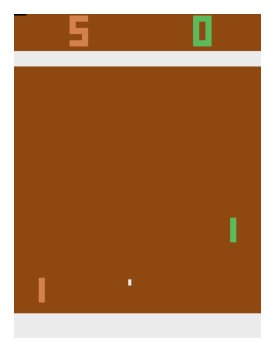

In [11]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)